if os.path.isfile(os.path.join(TEST_ANNOT_DIR, 'test.pkl')):
    test_db = pd.read_pickle(os.path.join(TEST_ANNOT_DIR, 'test.pkl'))
else:
    test_db = test_loader()
    test_db.to_pickle(os.path.join(TEST_ANNOT_DIR, 'test.pkl'))# Pangyo AI Challenge 2021 - Mask Classification Baseline

## 라이브러리 호출 및 I/O

In [1]:
import os, torch, copy, cv2, sys, random, logging
from datetime import datetime, timezone, timedelta
from PIL import Image
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import gc

import matplotlib.pyplot as plt
import json
import pandas as pd
import time

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# # 시드(seed) 설정

# RANDOM_SEED = 2021
# torch.manual_seed(RANDOM_SEED)
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False
# np.random.seed(RANDOM_SEED)
# random.seed(RANDOM_SEED)

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
seed = 100
seed_everything(seed)

In [5]:
def get_logger(name: str, file_path: str, stream=False) -> logging.RootLogger:
    logger = logging.getLogger(name)
    logger.setLevel(logging.INFO)

    formatter = logging.Formatter('%(asctime)s | %(name)s | %(levelname)s | %(message)s')
    stream_handler = logging.StreamHandler()
    file_handler = logging.FileHandler(file_path)

    stream_handler.setFormatter(formatter)
    file_handler.setFormatter(formatter)

    if stream:
        logger.addHandler(stream_handler)
    logger.addHandler(file_handler)

    return logger

## Argument Setting

In [6]:
# working directory 지정
ROOT_PATH = './'
TRAIN_DIR = os.path.join(ROOT_PATH, 'train')
RESULT_DIR = os.path.join(ROOT_PATH, 'results')
WEIGHT_DIR = os.path.join(ROOT_PATH, 'weights')
NUMPY_DIR = os.path.join(ROOT_PATH, 'numpy')
CSV_DIR = os.path.join(ROOT_PATH, 'csv')
TEST_ANNOT_DIR = os.path.join(ROOT_PATH, 'test_annot')

if not os.path.isdir(RESULT_DIR):
    os.makedirs(RESULT_DIR)

# hyper-parameters
EPOCHS = 20
BATCH_SIZE = 16
LEARNING_RATE = 1e-4
EARLY_STOPPING_PATIENCE = 5
INPUT_SHAPE = (180, 90)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Dataloader

#### Train & Validation Set loader

In [7]:
class CustomDataset(Dataset):
    def __init__(self, db, mode, transform):

        self.db = db
        self.mode = mode
        self.transform = transform

    def __len__(self):
        return len(self.db)

    def __getitem__(self, index):
        data = copy.deepcopy(self.db.loc[index])

        # Loading image
        cvimg = cv2.imread(data['img_path'], cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
        if not isinstance(cvimg, np.ndarray):
            raise IOError("Fail to read %s" % data['img_path'])

        # Preprocessing images
        trans_image = self.transform(Image.fromarray(cvimg))

        return trans_image, data['label']

    
def data_loader(data_dir=TRAIN_DIR):
    print('Loading ' + ' dataset..')
    if not os.path.isdir(data_dir):
        print(f'!!! Cannot find {data_dir}... !!!')
        sys.exit()
        
    mask_image_list = os.listdir(os.path.join(data_dir, 'Mask'))
    nomask_image_list = os.listdir(os.path.join(data_dir, 'NoMask'))
    mask_image_list = [item for item in mask_image_list if item[-4:] == '.png']
    nomask_image_list = [item for item in nomask_image_list  if item[-4:] == '.png']
    mask_image_path = list(map(lambda x : os.path.join(data_dir, 'Mask', x), mask_image_list))
    nomask_image_path = list(map(lambda x : os.path.join(data_dir, 'NoMask', x), nomask_image_list))

    # encoding label (Mask : 1, No Mask : 0)
    mask_df = pd.DataFrame({'img_path':mask_image_path, 'label':np.ones(len(mask_image_list))})
    nomask_df = pd.DataFrame({'img_path':nomask_image_path, 'label':np.zeros(len(nomask_image_list))})
    db = mask_df.append(nomask_df, ignore_index=True)
    return db


if os.path.isfile(os.path.join(TRAIN_DIR, 'total.pkl')):
    db = pd.read_pickle(os.path.join(TRAIN_DIR, 'total.pkl'))
else:
    db = data_loader()
    db.to_pickle(os.path.join(TRAIN_DIR, 'total.pkl'))
    
    
# Do stratified split
from sklearn.model_selection import train_test_split

train_idx, valid_idx= train_test_split(
    np.arange(len(db)),
    test_size=0.1,
    shuffle=True,
    stratify=db.label.values,
    random_state=seed)

train_db = db.iloc[train_idx]
valid_db = db.iloc[valid_idx]

train_db = train_db.reset_index()
valid_db = valid_db.reset_index()


transform = transforms.Compose([
                                transforms.Resize(INPUT_SHAPE),
                                transforms.ToTensor(), 
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [8]:
train_dataset = CustomDataset(db=train_db, mode='train', transform=transform)
validation_dataset = CustomDataset(db=valid_db, mode='val', transform=transform)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True)

print('Train set samples:',len(train_dataset),  'Val set samples:', len(validation_dataset))

Train set samples: 24388 Val set samples: 2710


## Model

In [9]:
# !pip install git+https://github.com/rwightman/pytorch-image-models.git

In [10]:
import timm

In [ ]:
timm.list_models(pretrained=True)

In [12]:
EFF_BACKBONES = [
    'efficientnet_b1',
    'efficientnet_b1_pruned',
    'tf_efficientnet_b1_ns',
    'tf_efficientnet_b4_ns',
    'tf_efficientnet_b7_ns',
    'efficientnetv2_rw_s',
    'efficientnetv2_rw_m',
    'tf_efficientnetv2_s_in21k',
    'tf_efficientnetv2_s_in21ft1k',
    'tf_efficientnetv2_m_in21k',
    'tf_efficientnetv2_m_in21ft1k',
    'tf_efficientnetv2_l_in21k',
]
NFN_BACKBONES = [
    'eca_nfnet_l0',
    'eca_nfnet_l1',
    'eca_nfnet_l2',
    'dm_nfnet_f2',
    'dm_nfnet_f4',
    'dm_nfnet_f6',
]
    
DEIT_BACKBONES = [
    'deit_base_distilled_patch16_224',
    'deit_base_distilled_patch16_384'   
]  

In [13]:
from torch.nn import functional as F
# for efficientnet
class EFFMaskClassifier(nn.Module):
    def __init__(self, backbone):
        super(EFFMaskClassifier, self).__init__()
        self.model = timm.create_model(backbone, pretrained=True)
        n_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(n_features, 1)

    def forward(self, input_img):
        x = self.model(input_img)
        return x


In [14]:
# for nfnet
class NFNMaskClassifier(nn.Module):
    def __init__(self, backbone):
        super(NFNMaskClassifier, self).__init__()
        self.model = timm.create_model(backbone, pretrained=True)
        n_features = self.model.head.fc.in_features
        self.model.head.fc = nn.Linear(n_features, 1)

    def forward(self, input_img):
        x = self.model(input_img)
        return x

In [15]:
# for deit
class DEITMaskClassifier(nn.Module):
    def __init__(self, backbone):
        super(DEITMaskClassifier, self).__init__()
        self.model = timm.create_model(backbone, pretrained=True)
        in_features_head = self.model.head.in_features
        in_features_head_dist = self.model.head_dist.in_features
        
        self.model.head = nn.Linear(in_features_head, 1)
        self.model.head_dist = nn.Linear(in_features_head_dist, 1)

    def forward(self, input_img):
        x = self.model(input_img)
        return x

## Just Trainer

In [16]:
class Trainer():
    """ Trainer
        epoch에 대한 학습 및 검증 절차 정의
    """
    def __init__(self, criterion, model, device, metric_fn, optimizer=None, scheduler=None, logger=None):
        """ 초기화
        """
        
        self.criterion = criterion
        self.model = model
        self.device = device
        self.optimizer = optimizer
        self.logger = logger
        self.scheduler = scheduler
        self.metric_fn = metric_fn

    def train_epoch(self, dataloader, epoch_index):
        """ 한 epoch에서 수행되는 학습 절차
        """
        self.model.train()
        train_total_loss = 0
        target_lst = []
        pred_lst = []
        prob_lst = []

        for batch_index, (img, label) in enumerate(dataloader):
            img = img.to(self.device)
            label = label.to(self.device)
            pred = self.model(img).squeeze()

            loss = self.criterion(pred, label)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            self.scheduler.step()
            train_total_loss += loss.item()
            prob_lst.extend(pred.cpu().tolist())
            target_lst.extend(label.cpu().tolist())
            pred_lst.extend((pred > 0.5).cpu().tolist())
        self.train_mean_loss = train_total_loss / batch_index
        self.train_score, auroc = self.metric_fn(y_pred=pred_lst, y_answer=target_lst, y_prob=prob_lst)
        msg = f'Epoch {epoch_index}, Train loss: {self.train_mean_loss}, Acc: {self.train_score}, ROC: {auroc}'
        print(msg)
        

    def validate_epoch(self, dataloader, epoch_index):
        """ 한 epoch에서 수행되는 검증 절차
        """
        self.model.eval()
        val_total_loss = 0
        target_lst = []
        pred_lst = []
        prob_lst = []

        for batch_index, (img, label) in enumerate(dataloader):
            img = img.to(self.device)
            label = label.to(self.device)
            pred = self.model(img).squeeze()
            ## coordinate loss
            loss = self.criterion(pred, label)
            val_total_loss += loss.item()
            prob_lst.extend(pred.cpu().tolist())
            target_lst.extend(label.cpu().tolist())
            pred_lst.extend((pred > 0.5).cpu().tolist())
        self.val_mean_loss = val_total_loss / batch_index
        self.validation_score, auroc = self.metric_fn(y_pred=pred_lst, y_answer=target_lst, y_prob=prob_lst)
        msg = f'Epoch {epoch_index}, Val loss: {self.val_mean_loss}, Acc: {self.validation_score}, ROC: {auroc}'
        print(msg)
    


## MultiScale Trainer

In [17]:
class MultiScale_Trainer():
    """ Trainer
        epoch에 대한 학습 및 검증 절차 정의
    """
    def __init__(self, criterion, model, device, metric_fn, scales, optimizer=None, scheduler=None, logger=None):
        """ 초기화
        """
        
        self.scales = scales
        self.scales_max_index = len(self.scales) - 1
        self.criterion = criterion
        self.model = model
        self.device = device
        self.optimizer = optimizer
        self.logger = logger
        self.scheduler = scheduler
        self.metric_fn = metric_fn

    def train_epoch(self, dataloader, epoch_index):
        """ 한 epoch에서 수행되는 학습 절차
        """
        self.model.train()
        train_total_loss = 0
        target_lst = []
        pred_lst = []
        prob_lst = []

        for batch_index, (img, label) in enumerate(dataloader):
            
            img = TF.resize(img, self.scales[np.random.randint(0, self.scales_max_index)])
            img = img.to(self.device)
            label = label.to(self.device)
            pred = self.model(img).squeeze()
            loss = self.criterion(pred, label)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            self.scheduler.step()
            train_total_loss += loss.item()
            prob_lst.extend(pred.cpu().tolist())
            target_lst.extend(label.cpu().tolist())
            pred_lst.extend((pred > 0.5).cpu().tolist())
        self.train_mean_loss = train_total_loss / batch_index
        self.train_score, auroc = self.metric_fn(y_pred=pred_lst, y_answer=target_lst, y_prob=prob_lst)
        msg = f'Epoch {epoch_index}, Train loss: {self.train_mean_loss}, Acc: {self.train_score}, ROC: {auroc}'
        print(msg)
        

    def validate_epoch(self, dataloader, epoch_index):
        """ 한 epoch에서 수행되는 검증 절차
        """
        self.model.eval()
        val_total_loss = 0
        target_lst = []
        pred_lst = []
        prob_lst = []

        for batch_index, (img, label) in enumerate(dataloader):
            img = img.to(self.device)
            label = label.to(self.device)
            pred = self.model(img).squeeze()

            ## coordinate loss
            loss = self.criterion(pred, label)
            val_total_loss += loss.item()
            prob_lst.extend(pred.cpu().tolist())
            target_lst.extend(label.cpu().tolist())
            pred_lst.extend((pred > 0.5).cpu().tolist())
        self.val_mean_loss = val_total_loss / batch_index
        self.validation_score, auroc = self.metric_fn(y_pred=pred_lst, y_answer=target_lst, y_prob=prob_lst)
        msg = f'Epoch {epoch_index}, Val loss: {self.val_mean_loss}, Acc: {self.validation_score}, ROC: {auroc}'
        print(msg)
    


## Metrics

In [18]:
from sklearn.metrics import accuracy_score, roc_auc_score

def get_metric_fn(y_pred, y_answer, y_prob):
    """ 성능을 반환하는 함수
    """
    assert len(y_pred) == len(y_answer), 'The size of prediction and answer are not same.'
    accuracy = accuracy_score(y_answer, y_pred)
    auroc = roc_auc_score(y_answer, y_prob)
    return accuracy, auroc

In [19]:
class TaylorSoftmax(nn.Module):

    def __init__(self, dim=1, n=2):
        super(TaylorSoftmax, self).__init__()
        assert n % 2 == 0
        self.dim = dim
        self.n = n

    def forward(self, x):
        
        fn = torch.ones_like(x)
        denor = 1.
        for i in range(1, self.n+1):
            denor *= i
            fn = fn + x.pow(i) / denor
        out = fn / fn.sum(dim=self.dim, keepdims=True)
        return out
    
class LabelSmoothingLoss(nn.Module):

    def __init__(self, classes, smoothing=0.0, dim=-1): 
        super(LabelSmoothingLoss, self).__init__() 
        self.confidence = 1.0 - smoothing 
        self.smoothing = smoothing 
        self.cls = classes 
        self.dim = dim 
    def forward(self, pred, target): 
        """Taylor Softmax and log are already applied on the logits"""
        #pred = pred.log_softmax(dim=self.dim) 
        with torch.no_grad(): 
            true_dist = torch.zeros_like(pred) 
            true_dist.fill_(self.smoothing / (self.cls - 1)) 
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence) 
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))
    
class TaylorCrossEntropyLoss(nn.Module):

    def __init__(self, n=2, ignore_index=-1, reduction='mean', smoothing=0.1):
        super(TaylorCrossEntropyLoss, self).__init__()
        assert n % 2 == 0
        self.taylor_softmax = TaylorSoftmax(dim=1, n=n)
        self.reduction = reduction
        self.ignore_index = ignore_index
        self.lab_smooth = LabelSmoothingLoss(2, smoothing=smoothing)

    def forward(self, logits, labels):

        log_probs = self.taylor_softmax(logits).log()
        #loss = F.nll_loss(log_probs, labels, reduction=self.reduction,
        #        ignore_index=self.ignore_index)
        loss = self.lab_smooth(log_probs, labels)
        return loss

#### Test set Loader

In [20]:
TEST_ANNOT_DIR = os.path.join(ROOT_PATH, 'test_annot')

In [21]:
class TestDataset(Dataset):
    def __init__(self, db, mode, transform):

        self.db = db
        self.mode = mode
        self.transform = transform

    def __len__(self):
        return len(self.db)

    def __getitem__(self, index):
        data = copy.deepcopy(self.db.loc[index])

        # Loading image
        cvimg = cv2.imread(data['img_path'], cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
        if not isinstance(cvimg, np.ndarray):
            raise IOError("Fail to read %s" % data['img_path'])

        # Preprocessing images
        trans_image = self.transform(Image.fromarray(cvimg))

        return trans_image, data['label']


In [22]:
def test_loader(data_dir=TEST_ANNOT_DIR):
    print('Loading ' + ' dataset..')
    if not os.path.isdir(data_dir):
        print(f'!!! Cannot find {data_dir}... !!!')
        sys.exit()
        
    mask_image_list = os.listdir(os.path.join(data_dir, 'Mask'))
    nomask_image_list = os.listdir(os.path.join(data_dir, 'NoMask'))
    mask_image_list = [item for item in mask_image_list if item[-4:] == '.png']
    nomask_image_list = [item for item in nomask_image_list  if item[-4:] == '.png']
    mask_image_path = list(map(lambda x : os.path.join(data_dir, 'Mask', x), mask_image_list))
    nomask_image_path = list(map(lambda x : os.path.join(data_dir, 'NoMask', x), nomask_image_list))

    # encoding label (Mask : 1, No Mask : 0)
    mask_df = pd.DataFrame({'img_path':mask_image_path, 'label':np.ones(len(mask_image_list))})
    nomask_df = pd.DataFrame({'img_path':nomask_image_path, 'label':np.zeros(len(nomask_image_list))})
    db = mask_df.append(nomask_df, ignore_index=True)
    return db

In [23]:
if os.path.isfile(os.path.join(TEST_ANNOT_DIR, 'test.pkl')):
    test_db = pd.read_pickle(os.path.join(TEST_ANNOT_DIR, 'test.pkl'))
else:
    test_db = test_loader()
    test_db.to_pickle(os.path.join(TEST_ANNOT_DIR, 'test.pkl'))

In [24]:
transform = transforms.Compose([
                                transforms.Resize(INPUT_SHAPE),
                                transforms.ToTensor(), 
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [25]:
test_dataset = TestDataset(db=test_db, mode='test', transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Misc.

In [26]:
def plot_loss(train_loss_history, valid_loss_history, backbone):
    plt.plot(train_loss_history, label="train loss")
    plt.plot(valid_loss_history, label="valid loss")
    plt.legend()
    plt.title(backbone)
    plt.show()

def plot_acc(train_acc_history, valid_acc_history, backbone):
    plt.plot(train_acc_history, label="train acc")
    plt.plot(valid_acc_history, label="valid acc")
    plt.legend()
    plt.title(backbone)
    plt.show()

In [27]:
def wait_and_flush():
    
    print("waiting...")
    
    time.sleep(120)
    
    gc.collect()
    torch.cuda.empty_cache()
    print("flushing...")
    time.sleep(60)
    
    gc.collect()
    torch.cuda.empty_cache()
    print("done!")

In [28]:
def pretty_size(size):

    """Pretty prints a torch.Size object"""
    assert(isinstance(size, torch.Size))
    return " × ".join(map(str, size))

def dump_tensors(gpu_only=True):
    """Prints a list of the Tensors being tracked by the garbage collector."""
    import gc
    total_size = 0
    for obj in gc.get_objects():
        try:
            if torch.is_tensor(obj):
                if not gpu_only or obj.is_cuda:
                    print("%s:%s%s %s" % (type(obj).__name__, 
                                          " GPU" if obj.is_cuda else "",
                                          " pinned" if obj.is_pinned else "",
                                          pretty_size(obj.size())))
                    total_size += obj.numel()
            elif hasattr(obj, "data") and torch.is_tensor(obj.data):
                if not gpu_only or obj.is_cuda:
                    print("%s → %s:%s%s%s%s %s" % (type(obj).__name__, 
                                                   type(obj.data).__name__, 
                                                   " GPU" if obj.is_cuda else "",
                                                   " pinned" if obj.data.is_pinned else "",
                                                   " grad" if obj.requires_grad else "", 
                                                   " volatile" if obj.volatile else "",
                                                   pretty_size(obj.data.size())))
                    total_size += obj.data.numel()
        except Exception as e:
            pass        
    print("Total size:", total_size)

# dump_tensors()

# 학습 Function

In [29]:
def EFF_train_val_infer(BACKBONE):
    model = EFFMaskClassifier(BACKBONE).to(device)
    # For Multi-GPU
#     os.environ["CUDA_VISIBLE_DEVICES"] = '0, 1'
#     model = nn.DataParallel(model)

    # Set optimizer, scheduler, loss function, metric function
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler =  optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, T_0=6, T_mult=1, eta_min=1e-6)
    # criterion = TaylorCrossEntropyLoss(n=2, smoothing=0.1)
#     criterion = nn.CrossEntropyLoss()
    criterion = nn.BCEWithLogitsLoss()
    metric_fn = get_metric_fn

    # Set system logger
    system_logger = get_logger(name='train',file_path='train_log.log')

    # Set trainer
    scales = [
        [140, 70], [180, 90], [220, 110], 
        [260, 130], [300, 150], [340, 170],
        [380, 190], [420, 210], [460, 230]
             ]

    trainer = Trainer(criterion, model, device, metric_fn, optimizer, scheduler, logger=system_logger)
    # trainer = MultiScale_Trainer(criterion, model, device, metric_fn, scales, optimizer, scheduler, logger=system_logger)

    train_loss_history = []
    train_acc_history = []

    valid_loss_history = []
    valid_acc_history = []

    best_val_loss = None
    best_val_acc = None
    
    for epoch_index in tqdm(range(EPOCHS)):

        trainer.train_epoch(train_dataloader, epoch_index)
        trainer.validate_epoch(validation_dataloader, epoch_index)

        train_loss_history.append(trainer.train_mean_loss)
        train_acc_history.append(trainer.train_score)

        valid_loss_history.append(trainer.val_mean_loss)
        valid_acc_history.append(trainer.validation_score)

        # don't use early stopper

        if best_val_loss == None or trainer.val_mean_loss < best_val_loss:
            best_val_loss = trainer.val_mean_loss
            criterion = trainer.val_mean_loss
            check_point = {
                'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict()
            }
            torch.save(check_point, os.path.join(WEIGHT_DIR, f'{BACKBONE}_best.pt'))

    best_val_acc = max(valid_acc_history)

    plot_loss(train_loss_history, valid_loss_history, BACKBONE)
    plot_acc(train_acc_history, valid_acc_history, BACKBONE)
    
    TRAINED_MODEL_PATH = os.path.join(WEIGHT_DIR, f'{BACKBONE}_best.pt')
    
    model.load_state_dict(torch.load(TRAINED_MODEL_PATH)['model'])

    # Prediction
    file_num_lst = []
    pred_lst = []
    prob_lst = []
    model.eval()
    with torch.no_grad():
        for batch_index, (img, file_num) in enumerate(test_dataloader):
            img = img.to(device)
            pred = model(img)
            file_num_lst.extend(list(file_num))
            
            pred_lst.extend((pred > 0.5).cpu().tolist())
            prob_lst.extend(pred.cpu().tolist())

    df = pd.DataFrame({'file_name':list(map(int,file_num_lst)), 'answer':pred_lst, 'prob':prob_lst})
    df.sort_values(by=['file_name'], inplace=True)
    df.to_csv(os.path.join(RESULT_DIR, f'mask_pred_with_{BACKBONE}.csv'), index=False)

    trainer.validate_epoch(test_dataloader, 0)
    
    # save data
    
    TIME = datetime.now().strftime('%m%d%H%M%S')

    save_dict = {'backbone':BACKBONE,
                 'time':TIME,
                 'best_val_loss':best_val_loss,
                 'best_val_acc':best_val_acc,
                 'test_acc':None,
                 'epochs':EPOCHS,
                 'input_shape':INPUT_SHAPE,
                 'augmentation':None,
                 'optimizer':'Adam',
                 'scheduler':'CosineAnnealingWarmRestarts',
                 'attention_module':None,
                 'learning_rate':LEARNING_RATE,
                 'batch_size':BATCH_SIZE,
                 'loss':'CrossEntropyLoss',
                 'freeze':None,
                 'others':None,
                 'randomeseed':seed,
                 'train_loss':train_loss_history,
                 'train_acc':train_acc_history,
                 'valid_loss':valid_loss_history,
                 'valid_acc':valid_acc_history}

    
    with open(f"{os.path.join(NUMPY_DIR, BACKBONE)}_{TIME}.json", 'w') as f:
        json.dump(save_dict, f)
        
    with open(f"{os.path.join(NUMPY_DIR, BACKBONE)}_{TIME}.json", 'r') as f:
        load_dict = json.load(f)

    save_csv = pd.read_csv(os.path.join(CSV_DIR, 'experiment.csv'))

    save_csv = save_csv.append(load_dict, ignore_index=True)

    save_csv.to_csv(os.path.join(CSV_DIR, 'experiment.csv'), 
                    index=False
                   )
    
    wait_and_flush()

In [30]:
def NFN_train_val_infer(BACKBONE):
    model = NFNMaskClassifier(BACKBONE).to(device)

    # For Multi-GPU
    os.environ["CUDA_VISIBLE_DEVICES"] = '0, 1'
    model = nn.DataParallel(model)

    # Set optimizer, scheduler, loss function, metric function
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler =  optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, T_0=6, T_mult=1, eta_min=1e-6)
    # criterion = TaylorCrossEntropyLoss(n=2, smoothing=0.1)
    criterion = nn.BCEWithLogitsLoss()
    metric_fn = get_metric_fn

    # Set system logger
    system_logger = get_logger(name='train',file_path='train_log.log')

    # Set trainer
    scales = [
        [140, 70], [180, 90], [220, 110], 
        [260, 130], [300, 150], [340, 170],
        [380, 190], [420, 210], [460, 230]
             ]

    trainer = Trainer(criterion, model, device, metric_fn, optimizer, scheduler, logger=system_logger)
    # trainer = MultiScale_Trainer(criterion, model, device, metric_fn, scales, optimizer, scheduler, logger=system_logger)

    train_loss_history = []
    train_acc_history = []

    valid_loss_history = []
    valid_acc_history = []

    best_val_loss = None
    best_val_acc = None

    for epoch_index in tqdm(range(EPOCHS)):

        trainer.train_epoch(train_dataloader, epoch_index)
        trainer.validate_epoch(validation_dataloader, epoch_index)

        train_loss_history.append(trainer.train_mean_loss)
        train_acc_history.append(trainer.train_score)

        valid_loss_history.append(trainer.val_mean_loss)
        valid_acc_history.append(trainer.validation_score)

        # don't use early stopper

        if best_val_loss == None or trainer.val_mean_loss < best_val_loss:
            best_val_loss = trainer.val_mean_loss
            criterion = trainer.val_mean_loss
            check_point = {
                'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict()
            }
            torch.save(check_point, os.path.join(WEIGHT_DIR, f'{BACKBONE}_best.pt'))

    best_val_acc = max(valid_acc_history)

    plot_loss(train_loss_history, valid_loss_history, BACKBONE)
    plot_acc(train_loss_history, valid_loss_history, BACKBONE)
    
    TRAINED_MODEL_PATH = os.path.join(WEIGHT_DIR, f'{BACKBONE}_best.pt')
    
    model.load_state_dict(torch.load(TRAINED_MODEL_PATH)['model'])

    # Prediction
    file_num_lst = []
    pred_lst = []
    prob_lst = []
    model.eval()
    with torch.no_grad():
        for batch_index, (img, file_num) in enumerate(test_dataloader):
            img = img.to(device)
            pred = model(img)
            file_num_lst.extend(list(file_num))
            pred_lst.extend((pred > 0.5).cpu().tolist())
            prob_lst.extend(pred.cpu().tolist())


    df = pd.DataFrame({'file_name':list(map(int,file_num_lst)), 'answer':pred_lst, 'prob':prob_lst})
    df.sort_values(by=['file_name'], inplace=True)
    df.to_csv(os.path.join(RESULT_DIR, f'mask_pred_with_{BACKBONE}.csv'), index=False)

    trainer.validate_epoch(test_dataloader, 0)
    
    # save data
    
    TIME = datetime.now().strftime('%m%d%H%M%S')

    save_dict = {'backbone':BACKBONE,
                 'time':TIME,
                 'best_val_loss':best_val_loss,
                 'best_val_acc':best_val_acc,
                 'test_acc':None,
                 'epochs':EPOCHS,
                 'input_shape':INPUT_SHAPE,
                 'augmentation':None,
                 'optimizer':'Adam',
                 'scheduler':'CosineAnnealingWarmRestarts',
                 'attention_module':None,
                 'learning_rate':LEARNING_RATE,
                 'batch_size':BATCH_SIZE,
                 'loss':'CrossEntropyLoss',
                 'freeze':None,
                 'others':None,
                 'randomeseed':seed,
                 'train_loss':train_loss_history,
                 'train_acc':train_acc_history,
                 'valid_loss':valid_loss_history,
                 'valid_acc':valid_acc_history}


    with open(f"{os.path.join(NUMPY_DIR, BACKBONE)}_{TIME}.json", 'w') as f:
        json.dump(save_dict, f)

    with open(f"{os.path.join(NUMPY_DIR, BACKBONE)}_{TIME}.json", 'r') as f:
        load_dict = json.load(f)
        
    save_csv = pd.read_csv(os.path.join(CSV_DIR, 'experiment.csv'))

    save_csv = save_csv.append(load_dict, ignore_index=True)

    save_csv.to_csv(os.path.join(CSV_DIR, 'experiment.csv'), 
                    index=False
                   )

    wait_and_flush()

In [31]:
def DEIT_train_val_infer(BACKBONE):
    model = DEITMaskClassifier(BACKBONE).to(device)

    # For Multi-GPU
#     os.environ["CUDA_VISIBLE_DEVICES"] = '0, 1'
#     model = nn.DataParallel(model)

    # Set optimizer, scheduler, loss function, metric function
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler =  optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, T_0=6, T_mult=1, eta_min=1e-6)
    # criterion = TaylorCrossEntropyLoss(n=2, smoothing=0.1)
    criterion = nn.BCEWithLogitsLoss()
    metric_fn = get_metric_fn

    # Set system logger
    system_logger = get_logger(name='train',file_path='train_log.log')

    # Set trainer
    scales = [
        [140, 70], [180, 90], [220, 110], 
        [260, 130], [300, 150], [340, 170],
        [380, 190], [420, 210], [460, 230]
             ]

    trainer = Trainer(criterion, model, device, metric_fn, optimizer, scheduler, logger=system_logger)
    # trainer = MultiScale_Trainer(criterion, model, device, metric_fn, scales, optimizer, scheduler, logger=system_logger)

    train_loss_history = []
    train_acc_history = []

    valid_loss_history = []
    valid_acc_history = []

    best_val_loss = None
    best_val_acc = None

    
    for epoch_index in tqdm(range(EPOCHS)):

        trainer.train_epoch(train_dataloader, epoch_index)
        trainer.validate_epoch(validation_dataloader, epoch_index)

        train_loss_history.append(trainer.train_mean_loss)
        train_acc_history.append(trainer.train_score)

        valid_loss_history.append(trainer.val_mean_loss)
        valid_acc_history.append(trainer.validation_score)

        # don't use early stopper

        if best_val_loss == None or trainer.val_mean_loss < best_val_loss:
            best_val_loss = trainer.val_mean_loss
            criterion = trainer.val_mean_loss
            check_point = {
                'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict()
            }
            torch.save(check_point, os.path.join(WEIGHT_DIR, f'{BACKBONE}_best.pt'))

    best_val_acc = max(valid_acc_history)

    plot_loss(train_loss_history, valid_loss_history, BACKBONE)
    plot_acc(train_loss_history, valid_loss_history, BACKBONE)
    
    TRAINED_MODEL_PATH = os.path.join(WEIGHT_DIR, f'{BACKBONE}_best.pt')
    
    model.load_state_dict(torch.load(TRAINED_MODEL_PATH)['model'])

    # Prediction
    file_num_lst = []
    pred_lst = []
    prob_lst = []
    model.eval()
    with torch.no_grad():
        for batch_index, (img, file_num) in enumerate(test_dataloader):
            img = img.to(device)
            pred = model(img)
            file_num_lst.extend(list(file_num))
            pred_lst.extend((pred > 0.5).cpu().tolist())
            prob_lst.extend(pred.cpu().tolist())

    df = pd.DataFrame({'file_name':list(map(int,file_num_lst)), 'answer':pred_lst, 'prob':prob_lst})
    df.sort_values(by=['file_name'], inplace=True)
    df.to_csv(os.path.join(RESULT_DIR, f'mask_pred_with_{BACKBONE}.csv'), index=False)

    trainer.validate_epoch(test_dataloader, 0)
    
    # save data
    
    TIME = datetime.now().strftime('%m%d%H%M%S')

    save_dict = {'backbone':BACKBONE,
                 'time':TIME,
                 'best_val_loss':best_val_loss,
                 'best_val_acc':best_val_acc,
                 'test_acc':None,
                 'epochs':EPOCHS,
                 'input_shape':INPUT_SHAPE,
                 'augmentation':None,
                 'optimizer':'Adam',
                 'scheduler':'CosineAnnealingWarmRestarts',
                 'attention_module':None,
                 'learning_rate':LEARNING_RATE,
                 'batch_size':BATCH_SIZE,
                 'loss':'CrossEntropyLoss',
                 'freeze':None,
                 'others':None,
                 'randomeseed':seed,
                 'train_loss':train_loss_history,
                 'train_acc':train_acc_history,
                 'valid_loss':valid_loss_history,
                 'valid_acc':valid_acc_history}


    with open(f"{os.path.join(NUMPY_DIR, BACKBONE)}_{TIME}.json", 'w') as f:
        json.dump(save_dict, f)
    
    with open(f"{os.path.join(NUMPY_DIR, BACKBONE)}_{TIME}.json", 'r') as f:
        load_dict = json.load(f)

    save_csv = pd.read_csv(os.path.join(CSV_DIR, 'experiment.csv'))

    save_csv = save_csv.append(load_dict, ignore_index=True)

    save_csv.to_csv(os.path.join(CSV_DIR, 'experiment.csv'), 
                    index=False
                   )
    
    wait_and_flush()

# 여기서부터 ㄹㅇ 학습save_csv

In [32]:
save_csv = pd.DataFrame()

# Efficient Family

In [33]:
len(EFF_BACKBONES)

12

In [34]:
INDEX = 0 

    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    efficientnet_b1    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0, Train loss: 0.3057872777438386, Acc: 0.8528784648187633, ROC: 0.9422300260857818


  5%|▌         | 1/20 [02:19<44:05, 139.24s/it]

Epoch 0, Val loss: 0.1807072214348293, Acc: 0.9047970479704797, ROC: 0.9856108612919352
Epoch 1, Train loss: 0.11994533488029084, Acc: 0.9514925373134329, ROC: 0.9910082271177363


 10%|█         | 2/20 [04:41<42:15, 140.85s/it]

Epoch 1, Val loss: 0.12521955913868524, Acc: 0.9476014760147602, ROC: 0.9905896593251594
Epoch 2, Train loss: 0.049140715404966305, Acc: 0.982409381663113, ROC: 0.9984416813476765


 15%|█▌        | 3/20 [07:00<39:45, 140.32s/it]

Epoch 2, Val loss: 0.1188292210252717, Acc: 0.9512915129151291, ROC: 0.9917092480031029
Epoch 3, Train loss: 0.027059565432734283, Acc: 0.9897080531408889, ROC: 0.9995285315800174


 20%|██        | 4/20 [09:19<37:16, 139.75s/it]

Epoch 3, Val loss: 0.11546667491400664, Acc: 0.9571955719557196, ROC: 0.9930890894996626
Epoch 4, Train loss: 0.015628915414496604, Acc: 0.9942184680990651, ROC: 0.9998353280158861


 25%|██▌       | 5/20 [11:40<35:02, 140.16s/it]

Epoch 4, Val loss: 0.13191759495814803, Acc: 0.9619926199261992, ROC: 0.9927179366576961
Epoch 5, Train loss: 0.013214308354685143, Acc: 0.9956946039035591, ROC: 0.9998533343912853


 30%|███       | 6/20 [13:59<32:33, 139.54s/it]

Epoch 5, Val loss: 0.1402425127822023, Acc: 0.9630996309963099, ROC: 0.9926070366343458
Epoch 6, Train loss: 0.013088349907066168, Acc: 0.9950795473183532, ROC: 0.9998240783315998


 35%|███▌      | 7/20 [16:16<30:06, 138.95s/it]

Epoch 6, Val loss: 0.14755334223501082, Acc: 0.9583025830258303, ROC: 0.9914924635353478
Epoch 7, Train loss: 0.012723968528611507, Acc: 0.9965966868951943, ROC: 0.9997835863487096


 40%|████      | 8/20 [18:35<27:47, 138.96s/it]

Epoch 7, Val loss: 0.14826981816276705, Acc: 0.9686346863468634, ROC: 0.9927240668097407
Epoch 8, Train loss: 0.013371571318578544, Acc: 0.9954485812694768, ROC: 0.9997896825079009


 45%|████▌     | 9/20 [20:52<25:22, 138.40s/it]

Epoch 8, Val loss: 0.12131823460657987, Acc: 0.9608856088560885, ROC: 0.994558096844142
Epoch 9, Train loss: 0.00720671255801965, Acc: 0.9973757585697884, ROC: 0.9999437240564047


 50%|█████     | 10/20 [23:09<22:57, 137.71s/it]

Epoch 9, Val loss: 0.1543689903607003, Acc: 0.9501845018450185, ROC: 0.9941590796747007
Epoch 10, Train loss: 0.006957120623722957, Acc: 0.9977037887485649, ROC: 0.9999572374386301


 55%|█████▌    | 11/20 [25:28<20:42, 138.10s/it]

Epoch 10, Val loss: 0.1356417088161082, Acc: 0.9656826568265683, ROC: 0.9938843374057977
Epoch 11, Train loss: 0.004404868163315823, Acc: 0.9984418566508119, ROC: 0.999979908820724


 60%|██████    | 12/20 [27:48<18:31, 138.97s/it]

Epoch 11, Val loss: 0.14403733863462273, Acc: 0.9653136531365314, ROC: 0.9947252828089916
Epoch 12, Train loss: 0.01028642951010358, Acc: 0.9965146793505002, ROC: 0.9998670610702769


 65%|██████▌   | 13/20 [30:05<16:06, 138.12s/it]

Epoch 12, Val loss: 0.14959633849477308, Acc: 0.9527675276752767, ROC: 0.9942989585986249
Epoch 13, Train loss: 0.008152272298589332, Acc: 0.9971297359357061, ROC: 0.9999189747509746


 70%|███████   | 14/20 [32:21<13:46, 137.70s/it]

Epoch 13, Val loss: 0.14201669098431155, Acc: 0.9612546125461254, ROC: 0.9934713880726189
Epoch 14, Train loss: 0.005515052688310065, Acc: 0.9980728226996883, ROC: 0.999971039803571


 75%|███████▌  | 15/20 [34:34<11:20, 136.19s/it]

Epoch 14, Val loss: 0.1258949279993562, Acc: 0.9708487084870848, ROC: 0.9951911743643729
Epoch 15, Train loss: 0.01011739959258769, Acc: 0.9980318189273413, ROC: 0.999907422322891


 80%|████████  | 16/20 [36:51<09:06, 136.55s/it]

Epoch 15, Val loss: 0.11893881675158323, Acc: 0.9719557195571956, ROC: 0.9958738503875092
Epoch 16, Train loss: 0.007548964681288735, Acc: 0.9972527472527473, ROC: 0.9999240250679571


 85%|████████▌ | 17/20 [39:09<06:50, 136.79s/it]

Epoch 16, Val loss: 0.12363116983666317, Acc: 0.9715867158671587, ROC: 0.995729513171189
Epoch 17, Train loss: 0.002885568431423052, Acc: 0.9988928981466295, ROC: 0.9999928098348139


 90%|█████████ | 18/20 [41:29<04:35, 137.91s/it]

Epoch 17, Val loss: 0.15525578066346762, Acc: 0.9645756457564576, ROC: 0.993697089125166
Epoch 18, Train loss: 0.004999109493577889, Acc: 0.9981958340167295, ROC: 0.9999780166719908


 95%|█████████▌| 19/20 [43:45<02:17, 137.22s/it]

Epoch 18, Val loss: 0.14600647523777047, Acc: 0.9686346863468634, ROC: 0.9941150540372903
Epoch 19, Train loss: 0.005081026388819624, Acc: 0.9980728226996883, ROC: 0.9999814087786288


100%|██████████| 20/20 [46:02<00:00, 138.13s/it]

Epoch 19, Val loss: 0.13691333311694256, Acc: 0.9653136531365314, ROC: 0.9959111885863257


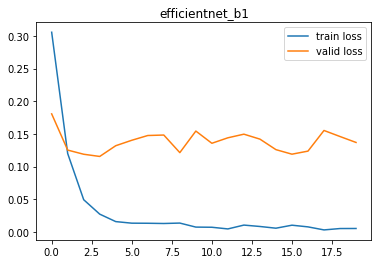

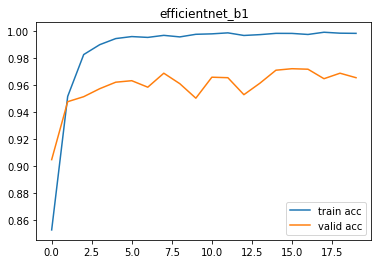

Epoch 0, Val loss: 0.11546651375108424, Acc: 0.9571955719557196, ROC: 0.9930890894996626


In [35]:
#0
try:
    print(f'\033[48;5;37m\033[38;5;255m    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    {EFF_BACKBONES[INDEX]}    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    \033[0;0m')    
    EFF_train_val_infer(EFF_BACKBONES[INDEX])
except:
    pass
INDEX += 1

    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    efficientnet_b1_pruned    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0, Train loss: 0.3392049713763757, Acc: 0.8303263900278826, ROC: 0.9278124135030008


  5%|▌         | 1/20 [02:11<41:40, 131.60s/it]

Epoch 0, Val loss: 0.20035441579363894, Acc: 0.9047970479704797, ROC: 0.9778712656924926
Epoch 1, Train loss: 0.1517327829595201, Acc: 0.9374692471707398, ROC: 0.9856794821693947


 10%|█         | 2/20 [04:24<39:41, 132.30s/it]

Epoch 1, Val loss: 0.13837236426072042, Acc: 0.9464944649446494, ROC: 0.9877268783203829
Epoch 2, Train loss: 0.07632726550503935, Acc: 0.970682302771855, ROC: 0.9961938155331953


 15%|█▌        | 3/20 [06:36<37:28, 132.24s/it]

Epoch 2, Val loss: 0.13988746375949304, Acc: 0.9509225092250922, ROC: 0.9881454005190567
Epoch 3, Train loss: 0.03696779382765308, Acc: 0.9862637362637363, ROC: 0.9990972455185868


 20%|██        | 4/20 [08:50<35:29, 133.08s/it]

Epoch 3, Val loss: 0.171759124550728, Acc: 0.9490774907749078, ROC: 0.987678951677126
Epoch 4, Train loss: 0.02727780177120481, Acc: 0.9901180908643595, ROC: 0.999435520428835


 25%|██▌       | 5/20 [11:06<33:29, 133.99s/it]

Epoch 4, Val loss: 0.2113054100590956, Acc: 0.951660516605166, ROC: 0.9868469228587239
Epoch 5, Train loss: 0.021509904233812303, Acc: 0.9916352304412006, ROC: 0.9996536335737147


 30%|███       | 6/20 [13:18<31:08, 133.47s/it]

Epoch 5, Val loss: 0.14620028508975977, Acc: 0.9619926199261992, ROC: 0.9908800056174484
Epoch 6, Train loss: 0.012495152984146466, Acc: 0.9949975397736591, ROC: 0.9999055508157803


 35%|███▌      | 7/20 [15:28<28:39, 132.28s/it]

Epoch 6, Val loss: 0.18018224613859923, Acc: 0.9549815498154982, ROC: 0.990185069290223
Epoch 7, Train loss: 0.015797061303371152, Acc: 0.9943414794161063, ROC: 0.999775887023501


 40%|████      | 8/20 [17:41<26:28, 132.35s/it]

Epoch 7, Val loss: 0.17974495223420084, Acc: 0.955719557195572, ROC: 0.9902307667872821
Epoch 8, Train loss: 0.014067978175008088, Acc: 0.9946695095948828, ROC: 0.9998533068691219


 45%|████▌     | 9/20 [19:52<24:12, 132.09s/it]

Epoch 8, Val loss: 0.16479437056972168, Acc: 0.951660516605166, ROC: 0.9909468800033882
Epoch 9, Train loss: 0.012412901332768301, Acc: 0.9952025586353944, ROC: 0.9998863197041103


 50%|█████     | 10/20 [22:03<21:56, 131.64s/it]

Epoch 9, Val loss: 0.21923065477876344, Acc: 0.9472324723247233, ROC: 0.988830305688391
Epoch 10, Train loss: 0.010569419699923558, Acc: 0.9960636378546827, ROC: 0.9999222980522042


 55%|█████▌    | 11/20 [24:19<19:56, 132.96s/it]

Epoch 10, Val loss: 0.16334601165067586, Acc: 0.9605166051660516, ROC: 0.9924487672542882
Epoch 11, Train loss: 0.011193475111074283, Acc: 0.9962276529440709, ROC: 0.9998277869431168


 60%|██████    | 12/20 [26:35<17:50, 133.83s/it]

Epoch 11, Val loss: 0.20895515131904085, Acc: 0.9527675276752767, ROC: 0.9887433689866693
Epoch 12, Train loss: 0.008477821912566885, Acc: 0.9970067246186649, ROC: 0.9999520288692082


 65%|██████▌   | 13/20 [28:45<15:28, 132.65s/it]

Epoch 12, Val loss: 0.2072603626372569, Acc: 0.9553505535055351, ROC: 0.9903895934538893
Epoch 13, Train loss: 0.006397959334358817, Acc: 0.997744792520912, ROC: 0.9999635537751285


 70%|███████   | 14/20 [30:56<13:12, 132.14s/it]

Epoch 13, Val loss: 0.21554662282321016, Acc: 0.9616236162361623, ROC: 0.9912288669974347
Epoch 14, Train loss: 0.008105378130206746, Acc: 0.9972937510250943, ROC: 0.9999462836176002


 75%|███████▌  | 15/20 [33:06<10:57, 131.47s/it]

Epoch 14, Val loss: 0.1939102080772833, Acc: 0.9616236162361623, ROC: 0.9912723353482957
Epoch 15, Train loss: 0.007389502279106212, Acc: 0.9975807774315237, ROC: 0.9999399397589384


 80%|████████  | 16/20 [35:19<08:47, 131.92s/it]

Epoch 15, Val loss: 0.1902268654903392, Acc: 0.9523985239852398, ROC: 0.990246370810668
Epoch 16, Train loss: 0.0072498936424456725, Acc: 0.9972937510250943, ROC: 0.9999629895707789


 85%|████████▌ | 17/20 [37:33<06:38, 132.75s/it]

Epoch 16, Val loss: 0.19035056040492088, Acc: 0.966789667896679, ROC: 0.9916858419680239
Epoch 17, Train loss: 0.006956905514056538, Acc: 0.9976217812038708, ROC: 0.9999522903297604


 90%|█████████ | 18/20 [39:48<04:26, 133.44s/it]

Epoch 17, Val loss: 0.1813033457596695, Acc: 0.9682656826568266, ROC: 0.9918558143656212
Epoch 18, Train loss: 0.008449424912598792, Acc: 0.9973347547974414, ROC: 0.9999326739078029


 95%|█████████▌| 19/20 [41:58<02:12, 132.44s/it]

Epoch 18, Val loss: 0.20581897133948548, Acc: 0.9638376383763838, ROC: 0.9903009848925189
Epoch 19, Train loss: 0.00795984955679348, Acc: 0.9972117434804002, ROC: 0.9999534875438679


100%|██████████| 20/20 [44:09<00:00, 132.48s/it]

Epoch 19, Val loss: 0.2087164586748883, Acc: 0.9649446494464945, ROC: 0.9922152641900481


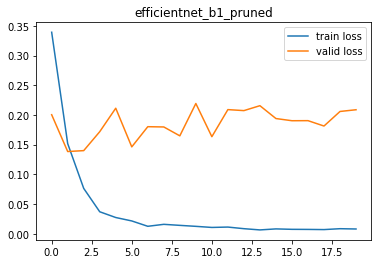

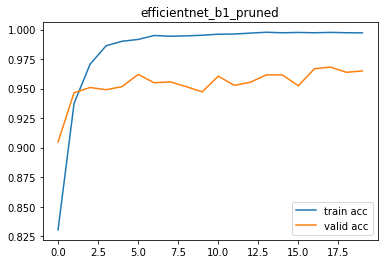

Epoch 0, Val loss: 0.1385105372207306, Acc: 0.9464944649446494, ROC: 0.9877268783203829


In [36]:
#1
try:
    print(f'\033[48;5;37m\033[38;5;255m    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    {EFF_BACKBONES[INDEX]}    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    \033[0;0m')    
    EFF_train_val_infer(EFF_BACKBONES[INDEX])
except:
    pass
INDEX += 1

    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    tf_efficientnet_b1_ns    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0, Train loss: 0.30387910540014296, Acc: 0.8517713629653928, ROC: 0.9426897219003734


  5%|▌         | 1/20 [02:20<44:21, 140.06s/it]

Epoch 0, Val loss: 0.16171962091818176, Acc: 0.9287822878228782, ROC: 0.984870227467651
Epoch 1, Train loss: 0.11420121758294928, Acc: 0.9544448089224209, ROC: 0.9917198539354753


 10%|█         | 2/20 [04:38<41:48, 139.35s/it]

Epoch 1, Val loss: 0.13890214056350467, Acc: 0.9527675276752767, ROC: 0.9896985581325104
Epoch 2, Train loss: 0.049457642304171025, Acc: 0.9823683778907659, ROC: 0.9983123822240623


 15%|█▌        | 3/20 [06:56<39:15, 138.58s/it]

Epoch 2, Val loss: 0.1284978528863437, Acc: 0.9571955719557196, ROC: 0.9910026086583382
Epoch 3, Train loss: 0.023810222577469013, Acc: 0.9909791700836477, ROC: 0.9995951489765073


 20%|██        | 4/20 [09:16<37:04, 139.01s/it]

Epoch 3, Val loss: 0.14001816540828896, Acc: 0.9638376383763838, ROC: 0.9921756968450336
Epoch 4, Train loss: 0.01760148018878247, Acc: 0.9935624077415122, ROC: 0.9997661785803644


 25%|██▌       | 5/20 [11:37<34:58, 139.92s/it]

Epoch 4, Val loss: 0.16745494501570207, Acc: 0.9605166051660516, ROC: 0.9924727305759166
Epoch 5, Train loss: 0.013776479894254016, Acc: 0.9951615548630474, ROC: 0.999848958367306


 30%|███       | 6/20 [14:00<32:52, 140.88s/it]

Epoch 5, Val loss: 0.14548158542344472, Acc: 0.962730627306273, ROC: 0.9921060360263464
Epoch 6, Train loss: 0.013782185719255718, Acc: 0.9949975397736591, ROC: 0.9998326858882006


 35%|███▌      | 7/20 [16:19<30:21, 140.12s/it]

Epoch 6, Val loss: 0.13592863558148044, Acc: 0.9634686346863469, ROC: 0.9929302628330553
Epoch 7, Train loss: 0.009884818099269544, Acc: 0.9968837133016237, ROC: 0.9999066585828569


 40%|████      | 8/20 [18:39<28:03, 140.30s/it]

Epoch 7, Val loss: 0.14834041244178764, Acc: 0.9649446494464945, ROC: 0.9935326895930637
Epoch 8, Train loss: 0.011032384525272382, Acc: 0.9961866491717238, ROC: 0.9998951818407225


 45%|████▌     | 9/20 [20:56<25:32, 139.31s/it]

Epoch 8, Val loss: 0.12051375174517771, Acc: 0.9656826568265683, ROC: 0.9944282490781087
Epoch 9, Train loss: 0.007491769817018744, Acc: 0.9968427095292767, ROC: 0.9999672692671864


 50%|█████     | 10/20 [23:13<23:05, 138.53s/it]

Epoch 9, Val loss: 0.145822729243174, Acc: 0.9697416974169741, ROC: 0.9942058917448586
Epoch 10, Train loss: 0.006665923759285229, Acc: 0.9976627849762179, ROC: 0.9999530127865494


 55%|█████▌    | 11/20 [25:34<20:53, 139.26s/it]

Epoch 10, Val loss: 0.16760783923480907, Acc: 0.9656826568265683, ROC: 0.9940470650782514
Epoch 11, Train loss: 0.00983423369102885, Acc: 0.9965146793505002, ROC: 0.9999024545723988


 60%|██████    | 12/20 [27:51<18:27, 138.44s/it]

Epoch 11, Val loss: 0.12791224105849258, Acc: 0.9664206642066421, ROC: 0.9948835521890493
Epoch 12, Train loss: 0.00784649237687645, Acc: 0.9972937510250943, ROC: 0.99996040248742


 65%|██████▌   | 13/20 [30:12<16:14, 139.17s/it]

Epoch 12, Val loss: 0.13944220028426177, Acc: 0.9645756457564576, ROC: 0.9949855356276077
Epoch 13, Train loss: 0.007820892587222229, Acc: 0.997785796293259, ROC: 0.9999422240984999


 70%|███████   | 14/20 [32:31<13:55, 139.21s/it]

Epoch 13, Val loss: 0.13796147319866853, Acc: 0.9642066420664207, ROC: 0.9949788481890137
Epoch 14, Train loss: 0.006834815918013645, Acc: 0.9979498113826472, ROC: 0.9999610286166373


 75%|███████▌  | 15/20 [34:48<11:32, 138.57s/it]

Epoch 14, Val loss: 0.1406496299770973, Acc: 0.9638376383763838, ROC: 0.9951616381772495
Epoch 15, Train loss: 0.0059608284962088766, Acc: 0.9981958340167295, ROC: 0.9999323642834648


 80%|████████  | 16/20 [37:07<09:15, 138.87s/it]

Epoch 15, Val loss: 0.14730864070826366, Acc: 0.966789667896679, ROC: 0.9943630465518174
Epoch 16, Train loss: 0.006600485082540662, Acc: 0.9971707397080531, ROC: 0.9999702141386693


 85%|████████▌ | 17/20 [39:24<06:54, 138.31s/it]

Epoch 16, Val loss: 0.16029879675131684, Acc: 0.9612546125461254, ROC: 0.9937243961660914
Epoch 17, Train loss: 0.004039946123342681, Acc: 0.9987288830572413, ROC: 0.9999899406492803


 90%|█████████ | 18/20 [41:44<04:37, 138.75s/it]

Epoch 17, Val loss: 0.1526670650516283, Acc: 0.9642066420664207, ROC: 0.9937856976865364
Epoch 18, Train loss: 0.006561847235822983, Acc: 0.9976217812038708, ROC: 0.9999684733618347


 95%|█████████▌| 19/20 [44:02<02:18, 138.49s/it]

Epoch 18, Val loss: 0.1788225398031736, Acc: 0.9634686346863469, ROC: 0.993971831394069
Epoch 19, Train loss: 0.004763545792705837, Acc: 0.9984828604231589, ROC: 0.9999828261700435


100%|██████████| 20/20 [46:25<00:00, 139.28s/it]

Epoch 19, Val loss: 0.16858674807099486, Acc: 0.9704797047970479, ROC: 0.9945319043763156


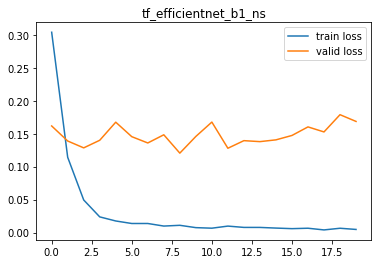

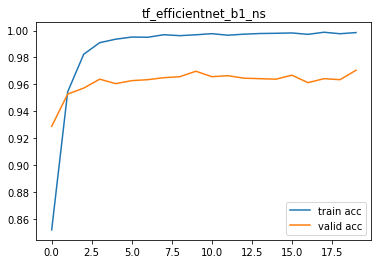

Epoch 0, Val loss: 0.1205085789373529, Acc: 0.9656826568265683, ROC: 0.9944282490781087


In [37]:
#2
try:
    print(f'\033[48;5;37m\033[38;5;255m    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    {EFF_BACKBONES[INDEX]}    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    \033[0;0m')    
    EFF_train_val_infer(EFF_BACKBONES[INDEX])
except:
    pass
INDEX += 1

    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    tf_efficientnet_b4_ns    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b4_ns-d6313a46.pth" to /home/ys/.cache/torch/hub/checkpoints/tf_efficientnet_b4_ns-d6313a46.pth
  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0, Train loss: 0.31348222200824827, Acc: 0.8454567820239463, ROC: 0.9387107360904431
Epoch 0, Val loss: 0.1536127242617149, Acc: 0.9343173431734317, ROC: 0.988522126226518


  5%|▌         | 1/20 [03:00<57:10, 180.55s/it]

Epoch 1, Train loss: 0.10005632978847398, Acc: 0.9613334426767263, ROC: 0.9935565936732105
Epoch 1, Val loss: 0.10974454389822659, Acc: 0.9531365313653136, ROC: 0.9926828276050776


 10%|█         | 2/20 [06:01<54:09, 180.52s/it]

Epoch 2, Train loss: 0.036415629760146596, Acc: 0.9871658192553715, ROC: 0.999063069872195
Epoch 2, Val loss: 0.10576710664236844, Acc: 0.9653136531365314, ROC: 0.9943496716746294


 15%|█▌        | 3/20 [09:02<51:18, 181.10s/it]

Epoch 3, Train loss: 0.023766922844995667, Acc: 0.9920042643923241, ROC: 0.9996133617681318


 20%|██        | 4/20 [12:03<48:14, 180.90s/it]

Epoch 3, Val loss: 0.12404629539802299, Acc: 0.9542435424354243, ROC: 0.9946946320487692
Epoch 4, Train loss: 0.02041956085532834, Acc: 0.9935624077415122, ROC: 0.9995899335265445
Epoch 4, Val loss: 0.09213159461000356, Acc: 0.9686346863468634, ROC: 0.9959006001418852


 25%|██▌       | 5/20 [15:01<44:57, 179.81s/it]

Epoch 5, Train loss: 0.015610798403211931, Acc: 0.9948745284566181, ROC: 0.9997169414300566


 30%|███       | 6/20 [17:59<41:50, 179.29s/it]

Epoch 5, Val loss: 0.10508522723660049, Acc: 0.9690036900369003, ROC: 0.9947358712534321
Epoch 6, Train loss: 0.013719397889985612, Acc: 0.9960226340823356, ROC: 0.9997802836891027


 35%|███▌      | 7/20 [21:00<38:55, 179.67s/it]

Epoch 6, Val loss: 0.10524025156693688, Acc: 0.9715867158671587, ROC: 0.9949966813585978
Epoch 7, Train loss: 0.012185756828669844, Acc: 0.9959816303099885, ROC: 0.9998337179693279


 40%|████      | 8/20 [24:01<36:02, 180.20s/it]

Epoch 7, Val loss: 0.10790286645560981, Acc: 0.9708487084870848, ROC: 0.9952725382005998
Epoch 8, Train loss: 0.009394637464504226, Acc: 0.9968427095292767, ROC: 0.9999229379425031


 45%|████▌     | 9/20 [27:00<32:57, 179.78s/it]

Epoch 8, Val loss: 0.10213979093130851, Acc: 0.9690036900369003, ROC: 0.9957841272530399
Epoch 9, Train loss: 0.012320225023586224, Acc: 0.9967607019845826, ROC: 0.9998138744895223


 50%|█████     | 10/20 [29:58<29:52, 179.21s/it]

Epoch 9, Val loss: 0.10116251119595265, Acc: 0.9693726937269372, ROC: 0.9966612962819513
Epoch 10, Train loss: 0.008571856167518238, Acc: 0.9973347547974414, ROC: 0.9999263988545496


 55%|█████▌    | 11/20 [32:54<26:44, 178.26s/it]

Epoch 10, Val loss: 0.10936145770698212, Acc: 0.9704797047970479, ROC: 0.9958465433465837
Epoch 11, Train loss: 0.012248273784204036, Acc: 0.9969657208463178, ROC: 0.9997549357766188


 60%|██████    | 12/20 [35:52<23:46, 178.36s/it]

Epoch 11, Val loss: 0.12956269930435801, Acc: 0.9678966789667897, ROC: 0.9948166778031096
Epoch 12, Train loss: 0.00690214906815895, Acc: 0.9979498113826472, ROC: 0.9999360040895733


 65%|██████▌   | 13/20 [38:54<20:56, 179.49s/it]

Epoch 12, Val loss: 0.10163067597008621, Acc: 0.9715867158671587, ROC: 0.9967064364924607
Epoch 13, Train loss: 0.008746304049551448, Acc: 0.9972117434804002, ROC: 0.9999387012615857


 70%|███████   | 14/20 [41:56<18:00, 180.15s/it]

Epoch 13, Val loss: 0.11344281314577938, Acc: 0.970110701107011, ROC: 0.9956035664110022
Epoch 14, Train loss: 0.005684224871089584, Acc: 0.9981138264720354, ROC: 0.9999754433497137


 75%|███████▌  | 15/20 [44:59<15:04, 180.84s/it]

Epoch 14, Val loss: 0.1180634811888138, Acc: 0.9730627306273063, ROC: 0.9960036981535424
Epoch 15, Train loss: 0.006820499356033564, Acc: 0.9981958340167295, ROC: 0.9998758268793171
Epoch 15, Val loss: 0.08167695226279141, Acc: 0.977490774907749, ROC: 0.9974793929366158


 80%|████████  | 16/20 [48:02<12:06, 181.69s/it]

Epoch 16, Train loss: 0.007211757527630032, Acc: 0.9978268000656061, ROC: 0.9999084819261815


 85%|████████▌ | 17/20 [51:02<09:03, 181.15s/it]

Epoch 16, Val loss: 0.10741381421159925, Acc: 0.9734317343173432, ROC: 0.995422448282415
Epoch 17, Train loss: 0.008738414014311288, Acc: 0.9972117434804002, ROC: 0.9998727306359356


 90%|█████████ | 18/20 [54:05<06:03, 181.81s/it]

Epoch 17, Val loss: 0.11007511779647712, Acc: 0.9693726937269372, ROC: 0.9950713577562306
Epoch 18, Train loss: 0.006887215868984307, Acc: 0.9981958340167295, ROC: 0.9999441024861513


 95%|█████████▌| 19/20 [57:08<03:02, 182.17s/it]

Epoch 18, Val loss: 0.12339700575031415, Acc: 0.9697416974169741, ROC: 0.9965554118375465
Epoch 19, Train loss: 0.0041140986910515, Acc: 0.9987288830572413, ROC: 0.9999849109739205


100%|██████████| 20/20 [1:00:09<00:00, 180.47s/it]

Epoch 19, Val loss: 0.09937827084737383, Acc: 0.9756457564575646, ROC: 0.995723940305694


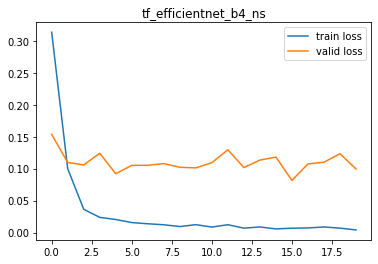

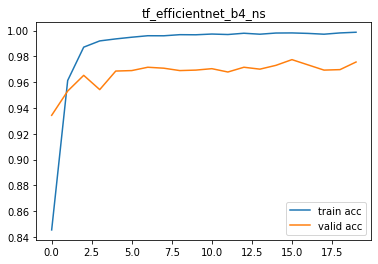

Epoch 0, Val loss: 0.08417256111494924, Acc: 0.977490774907749, ROC: 0.9974793929366158


In [38]:
#3
try:
    print(f'\033[48;5;37m\033[38;5;255m    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    {EFF_BACKBONES[INDEX]}    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    \033[0;0m')    
    EFF_train_val_infer(EFF_BACKBONES[INDEX])
except:
    pass
INDEX += 1

    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    tf_efficientnet_b7_ns    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0, Train loss: 0.2969262744265491, Acc: 0.8557077251107101, ROC: 0.9449273941935885
Epoch 0, Val loss: 0.13225686762442201, Acc: 0.9476014760147602, ROC: 0.9889779866240082


  5%|▌         | 1/20 [04:58<1:34:36, 298.75s/it]

Epoch 1, Train loss: 0.08468456022966776, Acc: 0.9683860915204199, ROC: 0.9950292289503544


 10%|█         | 2/20 [09:56<1:29:26, 298.16s/it]

Epoch 1, Val loss: 0.1333396920755575, Acc: 0.9616236162361623, ROC: 0.9905885447520604
Epoch 2, Train loss: 0.029052495933606957, Acc: 0.989749056913236, ROC: 0.9993192530495865
Epoch 2, Val loss: 0.11911221903460859, Acc: 0.9619926199261992, ROC: 0.9932902699440317


 15%|█▌        | 3/20 [14:55<1:24:38, 298.73s/it]

Epoch 3, Train loss: 0.020946618776022913, Acc: 0.9928653436116123, ROC: 0.9996144901768307


 20%|██        | 4/20 [20:00<1:20:14, 300.88s/it]

Epoch 3, Val loss: 0.1256804267072812, Acc: 0.962730627306273, ROC: 0.9940437213589544
Epoch 4, Train loss: 0.01942521981915821, Acc: 0.9931933737903887, ROC: 0.9997043913235499


 25%|██▌       | 5/20 [24:58<1:15:00, 300.00s/it]

Epoch 4, Val loss: 0.1341242228036948, Acc: 0.9649446494464945, ROC: 0.9916746962370341
Epoch 5, Train loss: 0.018160285427677256, Acc: 0.9945875020501886, ROC: 0.9996425215002452
Epoch 5, Val loss: 0.11580808016807234, Acc: 0.9678966789667897, ROC: 0.9946795853119327


 30%|███       | 6/20 [29:53<1:09:37, 298.36s/it]

Epoch 6, Train loss: 0.012648714243467696, Acc: 0.9958996227652944, ROC: 0.9998002647797251


 35%|███▌      | 7/20 [34:55<1:04:51, 299.33s/it]

Epoch 6, Val loss: 0.13901363527292565, Acc: 0.9616236162361623, ROC: 0.9952151376860013
Epoch 7, Train loss: 0.015125660139283018, Acc: 0.9947515171395769, ROC: 0.9997598071995392
Epoch 7, Val loss: 0.1091738951954323, Acc: 0.9693726937269372, ROC: 0.9944444103880443


 40%|████      | 8/20 [39:55<59:56, 299.69s/it]  

Epoch 8, Train loss: 0.01111692260836297, Acc: 0.9966786944398884, ROC: 0.999789909565749


 45%|████▌     | 9/20 [44:51<54:43, 298.53s/it]

Epoch 8, Val loss: 0.12437340266015424, Acc: 0.9712177121771217, ROC: 0.9941289862010277
Epoch 9, Train loss: 0.010192711304142019, Acc: 0.9968017057569296, ROC: 0.9998159592933993
Epoch 9, Val loss: 0.09409154580907335, Acc: 0.9726937269372694, ROC: 0.9960103855921364


 50%|█████     | 10/20 [49:52<49:53, 299.39s/it]

Epoch 10, Train loss: 0.007629011838091267, Acc: 0.9977037887485649, ROC: 0.9999409443179023


 55%|█████▌    | 11/20 [54:49<44:45, 298.43s/it]

Epoch 10, Val loss: 0.1102018892581497, Acc: 0.9704797047970479, ROC: 0.9955634417794381
Epoch 11, Train loss: 0.008046937432453058, Acc: 0.9974577661144826, ROC: 0.9998453873666059


 60%|██████    | 12/20 [59:50<39:55, 299.42s/it]

Epoch 11, Val loss: 0.13845376433302972, Acc: 0.9726937269372694, ROC: 0.9942777817097439
Epoch 12, Train loss: 0.00889130114628181, Acc: 0.9971297359357061, ROC: 0.9999062526309469


 65%|██████▌   | 13/20 [1:04:48<34:52, 298.94s/it]

Epoch 12, Val loss: 0.12102896678697007, Acc: 0.9708487084870848, ROC: 0.9940420494993057
Epoch 13, Train loss: 0.007174677924270667, Acc: 0.9974577661144826, ROC: 0.9999605194566145


 70%|███████   | 14/20 [1:09:53<30:05, 300.86s/it]

Epoch 13, Val loss: 0.1250684570026989, Acc: 0.970110701107011, ROC: 0.9941178404700378
Epoch 14, Train loss: 0.011389883068403227, Acc: 0.9982368377890766, ROC: 0.9998086590395596


 75%|███████▌  | 15/20 [1:14:56<25:07, 301.42s/it]

Epoch 14, Val loss: 0.1298061076652557, Acc: 0.9715867158671587, ROC: 0.9935003669731929
Epoch 15, Train loss: 0.006925215144219254, Acc: 0.9982778415614236, ROC: 0.9999473707430541


 80%|████████  | 16/20 [1:19:57<20:05, 301.27s/it]

Epoch 15, Val loss: 0.11000850976159478, Acc: 0.9708487084870848, ROC: 0.9950713577562305
Epoch 16, Train loss: 0.0066285948770091726, Acc: 0.997867803837953, ROC: 0.9999179633114701
Epoch 16, Val loss: 0.08787739506597268, Acc: 0.9789667896678966, ROC: 0.9962895861534354


 85%|████████▌ | 17/20 [1:24:56<15:02, 300.74s/it]

Epoch 17, Train loss: 0.0054302409230353645, Acc: 0.9984828604231589, ROC: 0.9999553659315195


 90%|█████████ | 18/20 [1:29:55<10:00, 300.16s/it]

Epoch 17, Val loss: 0.12393634166490085, Acc: 0.9719557195571956, ROC: 0.9953282668555495
Epoch 18, Train loss: 0.006854466700845962, Acc: 0.9979908151549942, ROC: 0.9998887278934071


 95%|█████████▌| 19/20 [1:34:51<04:58, 298.86s/it]

Epoch 18, Val loss: 0.10812718370260863, Acc: 0.9675276752767528, ROC: 0.9963598042586723
Epoch 19, Train loss: 0.004942350944781549, Acc: 0.9986468755125472, ROC: 0.9999522765686787


100%|██████████| 20/20 [1:39:47<00:00, 299.40s/it]

Epoch 19, Val loss: 0.10246412644571436, Acc: 0.9760147601476015, ROC: 0.9955054839782903


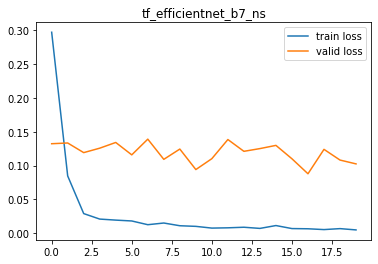

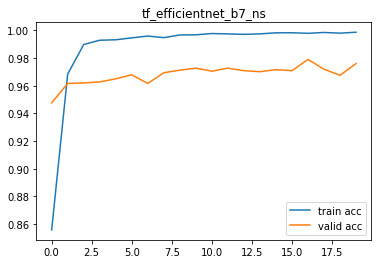

Epoch 0, Val loss: 0.08787707476501086, Acc: 0.9789667896678966, ROC: 0.9962895861534354


In [39]:
#4
try:
    print(f'\033[48;5;37m\033[38;5;255m    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    {EFF_BACKBONES[INDEX]}    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    \033[0;0m')    
    EFF_train_val_infer(EFF_BACKBONES[INDEX])
except:
    pass
INDEX += 1

    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    efficientnetv2_rw_s    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0, Train loss: 0.30208505028100413, Acc: 0.8505002460226341, ROC: 0.9438556605094909
Epoch 0, Val loss: 0.15510779139119352, Acc: 0.9265682656826568, ROC: 0.9875112084257268


  5%|▌         | 1/20 [03:23<1:04:19, 203.11s/it]

Epoch 1, Train loss: 0.09038564616085779, Acc: 0.9649007708709201, ROC: 0.994650224678557
Epoch 1, Val loss: 0.1147156412953117, Acc: 0.951660516605166, ROC: 0.9916841701083755


 10%|█         | 2/20 [06:45<1:00:53, 202.97s/it]

Epoch 2, Train loss: 0.031173817866549238, Acc: 0.9898720682302772, ROC: 0.9993095996507766


 15%|█▌        | 3/20 [10:07<57:19, 202.30s/it]  

Epoch 2, Val loss: 0.16343750826121453, Acc: 0.955719557195572, ROC: 0.9888297484018416
Epoch 3, Train loss: 0.0192562480309688, Acc: 0.9933163851074299, ROC: 0.9996550922483746
Epoch 3, Val loss: 0.10734279889258017, Acc: 0.9686346863468634, ROC: 0.99339225338259


 20%|██        | 4/20 [13:29<53:55, 202.23s/it]

Epoch 4, Train loss: 0.012755054122989388, Acc: 0.9967607019845826, ROC: 0.9998545384859336


 25%|██▌       | 5/20 [16:49<50:19, 201.29s/it]

Epoch 4, Val loss: 0.1343523155814351, Acc: 0.962730627306273, ROC: 0.9936831569614285
Epoch 5, Train loss: 0.012826961183738456, Acc: 0.9957766114482532, ROC: 0.9998457313936483


 30%|███       | 6/20 [20:14<47:18, 202.77s/it]

Epoch 5, Val loss: 0.13644465779152115, Acc: 0.9623616236162361, ROC: 0.9929352784120008
Epoch 6, Train loss: 0.008154843040923827, Acc: 0.9969247170739708, ROC: 0.9999445566018473


 35%|███▌      | 7/20 [23:33<43:38, 201.44s/it]

Epoch 6, Val loss: 0.1890836071969962, Acc: 0.9605166051660516, ROC: 0.9910616810325851
Epoch 7, Train loss: 0.00972465702389425, Acc: 0.9967607019845826, ROC: 0.9999066379412341


 40%|████      | 8/20 [26:55<40:20, 201.74s/it]

Epoch 7, Val loss: 0.16114286097619449, Acc: 0.9656826568265683, ROC: 0.9929603563067283
Epoch 8, Train loss: 0.008730210963368755, Acc: 0.9973347547974414, ROC: 0.9997708504676002


 45%|████▌     | 9/20 [30:16<36:54, 201.31s/it]

Epoch 8, Val loss: 0.14688637033607282, Acc: 0.9678966789667897, ROC: 0.9932663066224033
Epoch 9, Train loss: 0.008841405200051515, Acc: 0.9972527472527473, ROC: 0.9998741549078912


 50%|█████     | 10/20 [33:35<33:26, 200.61s/it]

Epoch 9, Val loss: 0.13513242032403083, Acc: 0.9653136531365314, ROC: 0.9927274105290376
Epoch 10, Train loss: 0.007130839494108513, Acc: 0.9974577661144826, ROC: 0.9999563429683198


 55%|█████▌    | 11/20 [36:57<30:09, 201.10s/it]

Epoch 10, Val loss: 0.13457071241577415, Acc: 0.966789667896679, ROC: 0.9939166600256687
Epoch 11, Train loss: 0.005256006719984081, Acc: 0.9981548302443825, ROC: 0.999976110762176


 60%|██████    | 12/20 [40:23<27:00, 202.61s/it]

Epoch 11, Val loss: 0.13907590479918197, Acc: 0.9690036900369003, ROC: 0.9946400179669184
Epoch 12, Train loss: 0.006454807701749298, Acc: 0.9978268000656061, ROC: 0.9999448799872671


 65%|██████▌   | 13/20 [43:45<23:36, 202.30s/it]

Epoch 12, Val loss: 0.11812339445991005, Acc: 0.9686346863468634, ROC: 0.9952396582941793
Epoch 13, Train loss: 0.006144732907006321, Acc: 0.9981138264720354, ROC: 0.9999540723898399


 70%|███████   | 14/20 [47:06<20:11, 202.00s/it]

Epoch 13, Val loss: 0.13654878094014797, Acc: 0.9630996309963099, ROC: 0.9939194464584161
Epoch 14, Train loss: 0.007175704841784363, Acc: 0.9975397736591767, ROC: 0.999948010633353


 75%|███████▌  | 15/20 [50:28<16:50, 202.09s/it]

Epoch 14, Val loss: 0.30924842135860164, Acc: 0.9734317343173432, ROC: 0.9944605716979796
Epoch 15, Train loss: 0.004130726214372518, Acc: 0.9989339019189766, ROC: 0.9999654665654841


 80%|████████  | 16/20 [53:55<13:33, 203.41s/it]

Epoch 15, Val loss: 2.1123858940197753, Acc: 0.9697416974169741, ROC: 0.9932378850083787
Epoch 16, Train loss: 0.005719104724386316, Acc: 0.9981548302443825, ROC: 0.9999552214401616


 85%|████████▌ | 17/20 [57:20<10:12, 204.05s/it]

Epoch 16, Val loss: 0.13383155519072149, Acc: 0.9671586715867159, ROC: 0.9941880585752746
Epoch 17, Train loss: 0.002926052981069057, Acc: 0.9989749056913236, ROC: 0.9999941515402793


 90%|█████████ | 18/20 [1:00:47<06:49, 204.72s/it]

Epoch 17, Val loss: 0.1481522148723057, Acc: 0.9678966789667897, ROC: 0.994042049499306
Epoch 18, Train loss: 0.005142427205476011, Acc: 0.9983598491061177, ROC: 0.9999754364691729


 95%|█████████▌| 19/20 [1:04:14<03:25, 205.53s/it]

Epoch 18, Val loss: 21.09259260169763, Acc: 0.9675276752767528, ROC: 0.9916557484943511
Epoch 19, Train loss: 0.003754609285447148, Acc: 0.9988108906019354, ROC: 0.9999818697748657


100%|██████████| 20/20 [1:07:38<00:00, 202.92s/it]

Epoch 19, Val loss: 3.404446955968857, Acc: 0.9586715867158672, ROC: 0.9903149170562564


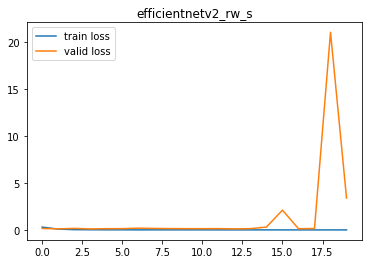

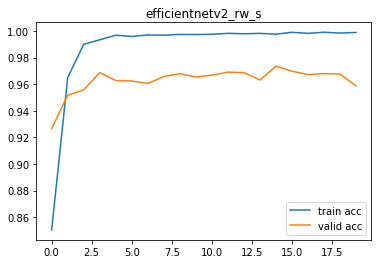

Epoch 0, Val loss: 0.10740399163851656, Acc: 0.9686346863468634, ROC: 0.99339225338259


In [40]:
#5
try:
    print(f'\033[48;5;37m\033[38;5;255m    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    {EFF_BACKBONES[INDEX]}    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    \033[0;0m')   
    EFF_train_val_infer(EFF_BACKBONES[INDEX])
except:
    pass
INDEX += 1

    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    efficientnetv2_rw_m    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnetv2_rw_m_agc-3d90cb1e.pth" to /home/ys/.cache/torch/hub/checkpoints/efficientnetv2_rw_m_agc-3d90cb1e.pth
  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0, Train loss: 0.2786020957625851, Acc: 0.8639084795801214, ROC: 0.9521345267934178
Epoch 0, Val loss: 0.1286673214037587, Acc: 0.9505535055350554, ROC: 0.9901466165183077


  5%|▌         | 1/20 [04:58<1:34:34, 298.63s/it]

Epoch 1, Train loss: 0.07582251642973176, Acc: 0.9719534197146138, ROC: 0.9960191805259336
Epoch 1, Val loss: 0.11584802610616955, Acc: 0.9531365313653136, ROC: 0.9930913186458606


 10%|█         | 2/20 [09:55<1:29:16, 297.61s/it]

Epoch 2, Train loss: 0.02345734820806479, Acc: 0.9912661964900771, ROC: 0.9995381918593678


 15%|█▌        | 3/20 [14:54<1:24:27, 298.11s/it]

Epoch 2, Val loss: 0.12368864200001167, Acc: 0.9597785977859778, ROC: 0.9932239528446413
Epoch 3, Train loss: 0.018149279417696045, Acc: 0.9938084303755945, ROC: 0.9997323194388518


 20%|██        | 4/20 [19:50<1:19:19, 297.45s/it]

Epoch 3, Val loss: 0.12144222125248068, Acc: 0.9649446494464945, ROC: 0.9938380826221892
Epoch 4, Train loss: 0.014678070773999154, Acc: 0.994136460554371, ROC: 0.9998278007041985


 25%|██▌       | 5/20 [24:48<1:14:22, 297.52s/it]

Epoch 4, Val loss: 0.14710117286621627, Acc: 0.9649446494464945, ROC: 0.9899615973838739
Epoch 5, Train loss: 0.010261411793988193, Acc: 0.9964736755781531, ROC: 0.9998746984706182


 30%|███       | 6/20 [29:45<1:09:24, 297.49s/it]

Epoch 5, Val loss: 0.12083443854729418, Acc: 0.9656826568265683, ROC: 0.994235427931982
Epoch 6, Train loss: 0.009650829408292516, Acc: 0.9963916680334591, ROC: 0.9999329491294368
Epoch 6, Val loss: 0.11542720208149922, Acc: 0.9682656826568266, ROC: 0.9943535726804759


 35%|███▌      | 7/20 [34:45<1:04:39, 298.39s/it]

Epoch 7, Train loss: 0.009298569873512215, Acc: 0.9967607019845826, ROC: 0.9999260582677775


 40%|████      | 8/20 [39:46<59:50, 299.22s/it]  

Epoch 7, Val loss: 0.14111505044750874, Acc: 0.9590405904059041, ROC: 0.9926198542249843
Epoch 8, Train loss: 0.007683804206545243, Acc: 0.9974987698868296, ROC: 0.9999282841227419


 45%|████▌     | 9/20 [44:43<54:43, 298.47s/it]

Epoch 8, Val loss: 0.1261430870995032, Acc: 0.959409594095941, ROC: 0.9947135797914521
Epoch 9, Train loss: 0.006751384349967869, Acc: 0.9979088076103001, ROC: 0.9999378824772248


 50%|█████     | 10/20 [49:38<49:33, 297.31s/it]

Epoch 9, Val loss: 0.13772139385412285, Acc: 0.9678966789667897, ROC: 0.9941718972653392
Epoch 10, Train loss: 0.008568292627501493, Acc: 0.9974577661144826, ROC: 0.9998444997768364


 55%|█████▌    | 11/20 [54:29<44:17, 295.28s/it]

Epoch 10, Val loss: 0.12064410349656672, Acc: 0.970110701107011, ROC: 0.9947068923528581
Epoch 11, Train loss: 0.006026102235529312, Acc: 0.9981548302443825, ROC: 0.9999404145162568


 60%|██████    | 12/20 [59:23<39:19, 294.90s/it]

Epoch 11, Val loss: 0.11938325829076259, Acc: 0.9719557195571956, ROC: 0.9947537044230161
Epoch 12, Train loss: 0.007453105070591806, Acc: 0.9977037887485649, ROC: 0.9999620813393869


 65%|██████▌   | 13/20 [1:04:21<34:30, 295.81s/it]

Epoch 12, Val loss: 0.12831967945372091, Acc: 0.970110701107011, ROC: 0.9936976464117154
Epoch 13, Train loss: 0.008891301326594075, Acc: 0.9975397736591767, ROC: 0.999760357642807
Epoch 13, Val loss: 0.11264217045139087, Acc: 0.9708487084870848, ROC: 0.9948450994171341


 70%|███████   | 14/20 [1:09:21<29:42, 297.13s/it]

Epoch 14, Train loss: 0.006228226421061116, Acc: 0.9981958340167295, ROC: 0.9999489051036632


 75%|███████▌  | 15/20 [1:14:21<24:50, 298.01s/it]

Epoch 14, Val loss: 0.11436928392031015, Acc: 0.9734317343173432, ROC: 0.9950016969375431
Epoch 15, Train loss: 0.003916787003611832, Acc: 0.9986058717402001, ROC: 0.9999890255373476


 80%|████████  | 16/20 [1:19:15<19:47, 296.93s/it]

Epoch 15, Val loss: 0.12265778827380955, Acc: 0.9760147601476015, ROC: 0.9946283149493788
Epoch 16, Train loss: 0.005163112224123169, Acc: 0.9984828604231589, ROC: 0.9998908333389065


 85%|████████▌ | 17/20 [1:24:11<14:49, 296.50s/it]

Epoch 16, Val loss: 0.11574379250422498, Acc: 0.9730627306273063, ROC: 0.9950290039784686
Epoch 17, Train loss: 0.006687433532831077, Acc: 0.997785796293259, ROC: 0.9999125001620368
Epoch 17, Val loss: 0.0910712964377025, Acc: 0.9782287822878228, ROC: 0.9958989282822366


 90%|█████████ | 18/20 [1:29:12<09:55, 297.80s/it]

Epoch 18, Train loss: 0.004640847698598141, Acc: 0.9986058717402001, ROC: 0.9999750993226714


 95%|█████████▌| 19/20 [1:34:11<04:58, 298.33s/it]

Epoch 18, Val loss: 0.09202932062649215, Acc: 0.9763837638376384, ROC: 0.9961926182938227
Epoch 19, Train loss: 0.0045890404877874, Acc: 0.998564867967853, ROC: 0.9999787322482391


100%|██████████| 20/20 [1:39:08<00:00, 297.42s/it]

Epoch 19, Val loss: 0.09360509841983264, Acc: 0.9734317343173432, ROC: 0.9958114342939653


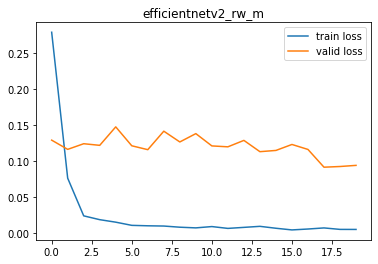

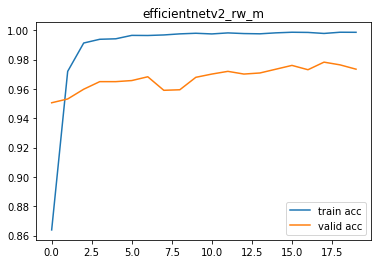

Epoch 0, Val loss: 0.09106909474683673, Acc: 0.9782287822878228, ROC: 0.9958989282822366


In [41]:
#6
try:
    print(f'\033[48;5;37m\033[38;5;255m    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    {EFF_BACKBONES[INDEX]}    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    \033[0;0m')    
    EFF_train_val_infer(EFF_BACKBONES[INDEX])
except:
    pass
INDEX += 1

    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    tf_efficientnetv2_s_in21k    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-effv2-weights/tf_efficientnetv2_s_21k-6337ad01.pth" to /home/ys/.cache/torch/hub/checkpoints/tf_efficientnetv2_s_21k-6337ad01.pth
  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0, Train loss: 0.25522093820823394, Acc: 0.8852714449729375, ROC: 0.9598802612502829
Epoch 0, Val loss: 0.1156256645204936, Acc: 0.9490774907749078, ROC: 0.9923913667396898


  5%|▌         | 1/20 [03:22<1:04:16, 202.95s/it]

Epoch 1, Train loss: 0.06358635688169356, Acc: 0.9770788912579957, ROC: 0.9971286814987459
Epoch 1, Val loss: 0.10767204012351733, Acc: 0.9653136531365314, ROC: 0.9932585046107102


 10%|█         | 2/20 [06:49<1:01:35, 205.29s/it]

Epoch 2, Train loss: 0.025392664181122494, Acc: 0.9917582417582418, ROC: 0.9995604228868475


 15%|█▌        | 3/20 [10:16<58:17, 205.71s/it]  

Epoch 2, Val loss: 0.11564895424653623, Acc: 0.9616236162361623, ROC: 0.9943936973120397
Epoch 3, Train loss: 0.014750990726138953, Acc: 0.9950795473183532, ROC: 0.9997835863487097
Epoch 3, Val loss: 0.091723243255662, Acc: 0.974169741697417, ROC: 0.9956180558612892


 20%|██        | 4/20 [13:36<54:18, 203.64s/it]

Epoch 4, Train loss: 0.012175570509877024, Acc: 0.9958176152206003, ROC: 0.9998834436380359


 25%|██▌       | 5/20 [16:59<50:49, 203.32s/it]

Epoch 4, Val loss: 0.10875262747843903, Acc: 0.9749077490774908, ROC: 0.9943101043296149
Epoch 5, Train loss: 0.013091714283847979, Acc: 0.9954075774971297, ROC: 0.9998389402998314


 30%|███       | 6/20 [20:28<47:52, 205.19s/it]

Epoch 5, Val loss: 0.11192996612367477, Acc: 0.9752767527675277, ROC: 0.9955405930309088
Epoch 6, Train loss: 0.0085845253349974, Acc: 0.9971707397080531, ROC: 0.999912080449045


 35%|███▌      | 7/20 [23:52<44:25, 205.08s/it]

Epoch 6, Val loss: 0.1343230240054995, Acc: 0.9730627306273063, ROC: 0.9935616684936377
Epoch 7, Train loss: 0.010964494746279137, Acc: 0.9959816303099885, ROC: 0.9998987803635859


 40%|████      | 8/20 [27:19<41:06, 205.56s/it]

Epoch 7, Val loss: 0.1533774299108322, Acc: 0.9693726937269372, ROC: 0.9926120522132913
Epoch 8, Train loss: 0.009213767274289273, Acc: 0.9971707397080531, ROC: 0.9998847096575519


 45%|████▌     | 9/20 [30:48<37:53, 206.66s/it]

Epoch 8, Val loss: 0.12005400819545059, Acc: 0.9734317343173432, ROC: 0.9953048608204708
Epoch 9, Train loss: 0.006801821763279102, Acc: 0.9975807774315237, ROC: 0.9999654252822391


 50%|█████     | 10/20 [34:14<34:23, 206.31s/it]

Epoch 9, Val loss: 0.118553071572082, Acc: 0.9719557195571956, ROC: 0.9955695719314827
Epoch 10, Train loss: 0.0069244200123224995, Acc: 0.9978268000656061, ROC: 0.9999671935812371


 55%|█████▌    | 11/20 [37:38<30:50, 205.61s/it]

Epoch 10, Val loss: 0.11532548520203273, Acc: 0.9749077490774908, ROC: 0.9953444281654852
Epoch 11, Train loss: 0.00688884219720843, Acc: 0.9978268000656061, ROC: 0.9999325156553635


 60%|██████    | 12/20 [41:02<27:22, 205.26s/it]

Epoch 11, Val loss: 0.14520016161717825, Acc: 0.9693726937269372, ROC: 0.9946623094288983
Epoch 12, Train loss: 0.006574301562900098, Acc: 0.9977037887485649, ROC: 0.9999640010102836


 65%|██████▌   | 13/20 [44:27<23:55, 205.10s/it]

Epoch 12, Val loss: 0.11349895028825199, Acc: 0.9738007380073801, ROC: 0.9957172528671
Epoch 13, Train loss: 0.005479142626124235, Acc: 0.9980318189273413, ROC: 0.9999692026991646


 70%|███████   | 14/20 [47:53<20:31, 205.26s/it]

Epoch 13, Val loss: 0.11621760204694356, Acc: 0.9745387453874539, ROC: 0.994901942645183
Epoch 14, Train loss: 0.005353962439695441, Acc: 0.9980728226996883, ROC: 0.9999612556744852
Epoch 14, Val loss: 0.08377755144310348, Acc: 0.9808118081180812, ROC: 0.9967003063404163


 75%|███████▌  | 15/20 [51:13<16:59, 203.80s/it]

Epoch 15, Train loss: 0.004692974358493416, Acc: 0.9983188453337707, ROC: 0.9999773974233146


 80%|████████  | 16/20 [54:34<13:32, 203.02s/it]

Epoch 15, Val loss: 0.13815140120778868, Acc: 0.9697416974169741, ROC: 0.9946924029025712
Epoch 16, Train loss: 0.0053923545194985165, Acc: 0.9980318189273413, ROC: 0.9999675651304427


 85%|████████▌ | 17/20 [58:01<10:12, 204.11s/it]

Epoch 16, Val loss: 0.08713009344301056, Acc: 0.977859778597786, ROC: 0.9970084858022892
Epoch 17, Train loss: 0.004991518888148646, Acc: 0.9987288830572413, ROC: 0.9999622946361533


 90%|█████████ | 18/20 [1:01:29<06:50, 205.44s/it]

Epoch 17, Val loss: 0.12049540399279147, Acc: 0.9763837638376384, ROC: 0.9959078448670287
Epoch 18, Train loss: 0.004408203264726315, Acc: 0.9983598491061177, ROC: 0.9999838238484665


 95%|█████████▌| 19/20 [1:04:58<03:26, 206.30s/it]

Epoch 18, Val loss: 0.10617320983670073, Acc: 0.9760147601476015, ROC: 0.9969427259894483
Epoch 19, Train loss: 0.004276994602970623, Acc: 0.9987698868295883, ROC: 0.999921265971077


100%|██████████| 20/20 [1:08:26<00:00, 205.31s/it]

Epoch 19, Val loss: 0.10241446100909178, Acc: 0.9756457564575646, ROC: 0.9970881777788676


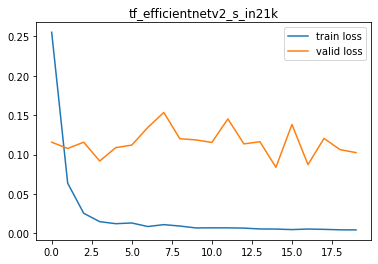

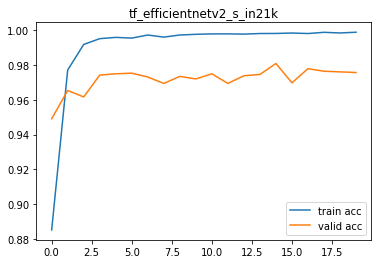

Epoch 0, Val loss: 0.08379145969079578, Acc: 0.9808118081180812, ROC: 0.9967003063404163


In [42]:
#7
try:
    print(f'\033[48;5;37m\033[38;5;255m    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    {EFF_BACKBONES[INDEX]}    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    \033[0;0m')   
    EFF_train_val_infer(EFF_BACKBONES[INDEX])
except:
    pass
INDEX += 1

    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    tf_efficientnetv2_s_in21ft1k    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0, Train loss: 0.25582787770034404, Acc: 0.8801049696572084, ROC: 0.9595334407083015
Epoch 0, Val loss: 0.11326622048514112, Acc: 0.9612546125461254, ROC: 0.9929202316751644


  5%|▌         | 1/20 [03:25<1:05:09, 205.75s/it]

Epoch 1, Train loss: 0.06088477481818172, Acc: 0.978021978021978, ROC: 0.9973540054504343
Epoch 1, Val loss: 0.0920230492402105, Acc: 0.9616236162361623, ROC: 0.994869620025312


 10%|█         | 2/20 [06:53<1:02:06, 207.04s/it]

Epoch 2, Train loss: 0.02539802707119017, Acc: 0.9908561587666065, ROC: 0.9994812313019582


 15%|█▌        | 3/20 [10:14<57:53, 204.31s/it]  

Epoch 2, Val loss: 0.09230290627747152, Acc: 0.9690036900369003, ROC: 0.9947709803060506
Epoch 3, Train loss: 0.01710113129983736, Acc: 0.9944644907331475, ROC: 0.9996536748569599


 20%|██        | 4/20 [13:37<54:19, 203.73s/it]

Epoch 3, Val loss: 0.11196409229535433, Acc: 0.9660516605166052, ROC: 0.9933816649381496
Epoch 4, Train loss: 0.014672917320852824, Acc: 0.9951615548630474, ROC: 0.9998206931055026


 25%|██▌       | 5/20 [17:04<51:14, 204.97s/it]

Epoch 4, Val loss: 0.09755358386171674, Acc: 0.9726937269372694, ROC: 0.9950122853819838
Epoch 5, Train loss: 0.01150156041835457, Acc: 0.9959816303099885, ROC: 0.9999015325799252


 30%|███       | 6/20 [20:33<48:05, 206.13s/it]

Epoch 5, Val loss: 0.1014771671002559, Acc: 0.9715867158671587, ROC: 0.9954319221537565
Epoch 6, Train loss: 0.011185487372874732, Acc: 0.9964326718058061, ROC: 0.9997949323605679


 35%|███▌      | 7/20 [24:05<45:05, 208.13s/it]

Epoch 6, Val loss: 0.11491831726738028, Acc: 0.9745387453874539, ROC: 0.9944432958149453
Epoch 7, Train loss: 0.009861218033842182, Acc: 0.9965966868951943, ROC: 0.9999020348594071


 40%|████      | 8/20 [27:31<41:28, 207.39s/it]

Epoch 7, Val loss: 0.10413107272430118, Acc: 0.9708487084870848, ROC: 0.995690503112724
Epoch 8, Train loss: 0.008781614355855595, Acc: 0.9969247170739708, ROC: 0.9999058191568734


 45%|████▌     | 9/20 [30:59<38:05, 207.79s/it]

Epoch 8, Val loss: 0.10088775911014092, Acc: 0.9723247232472325, ROC: 0.9954246774286131
Epoch 9, Train loss: 0.01010681397972003, Acc: 0.9965556831228473, ROC: 0.9998641368404165


 50%|█████     | 10/20 [34:24<34:28, 206.82s/it]

Epoch 9, Val loss: 0.09230176325676455, Acc: 0.9749077490774908, ROC: 0.995752919206268
Epoch 10, Train loss: 0.007009902268837658, Acc: 0.9974987698868296, ROC: 0.9999604300095835


 55%|█████▌    | 11/20 [37:49<30:56, 206.26s/it]

Epoch 10, Val loss: 0.12197393836314399, Acc: 0.9726937269372694, ROC: 0.9953539020368266
Epoch 11, Train loss: 0.0054573809741535065, Acc: 0.9980318189273413, ROC: 0.9999610148555556


 60%|██████    | 12/20 [41:06<27:07, 203.48s/it]

Epoch 11, Val loss: 0.09569132789078384, Acc: 0.9760147601476015, ROC: 0.9966161560714419
Epoch 12, Train loss: 0.010112471465765748, Acc: 0.9974577661144826, ROC: 0.9998960006250833


 65%|██████▌   | 13/20 [44:31<23:47, 203.90s/it]

Epoch 12, Val loss: 0.1157293854573962, Acc: 0.9726937269372694, ROC: 0.9946946320487692
Epoch 13, Train loss: 0.009263591181548797, Acc: 0.9968017057569296, ROC: 0.9998540706091559


 70%|███████   | 14/20 [48:00<20:32, 205.37s/it]

Epoch 13, Val loss: 0.09708053364654362, Acc: 0.9771217712177122, ROC: 0.99629571630548
Epoch 14, Train loss: 0.004472622956035147, Acc: 0.998564867967853, ROC: 0.9999731865323156


 75%|███████▌  | 15/20 [51:29<17:11, 206.40s/it]

Epoch 14, Val loss: 0.09462852039662124, Acc: 0.9793357933579335, ROC: 0.9962188107616491
Epoch 15, Train loss: 0.00492348302029437, Acc: 0.998523864195506, ROC: 0.9999539554206456


 80%|████████  | 16/20 [54:54<13:44, 206.23s/it]

Epoch 15, Val loss: 0.10093066250978962, Acc: 0.9763837638376384, ROC: 0.995998682574597
Epoch 16, Train loss: 0.004643676062548113, Acc: 0.9983598491061177, ROC: 0.9999826059927364


 85%|████████▌ | 17/20 [58:24<10:21, 207.17s/it]

Epoch 16, Val loss: 0.11209024705453077, Acc: 0.9767527675276753, ROC: 0.9954525417560879
Epoch 17, Train loss: 0.0035592329653676845, Acc: 0.9986468755125472, ROC: 0.9999897686357591


 90%|█████████ | 18/20 [1:01:50<06:53, 206.97s/it]

Epoch 17, Val loss: 0.1198661036535692, Acc: 0.9763837638376384, ROC: 0.9957451171945749
Epoch 18, Train loss: 0.005942286989575625, Acc: 0.9981958340167295, ROC: 0.9999606845895949


 95%|█████████▌| 19/20 [1:05:16<03:26, 206.57s/it]

Epoch 18, Val loss: 0.14094598400599015, Acc: 0.9749077490774908, ROC: 0.9937907132654819
Epoch 19, Train loss: 0.004956889761473595, Acc: 0.998523864195506, ROC: 0.9999456230856787


100%|██████████| 20/20 [1:08:40<00:00, 206.05s/it]

Epoch 19, Val loss: 0.13345401667341797, Acc: 0.9763837638376384, ROC: 0.9941746836980866


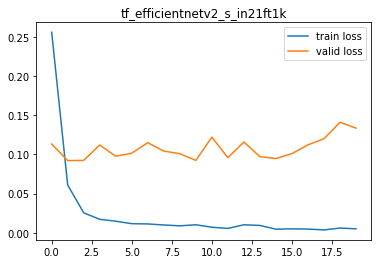

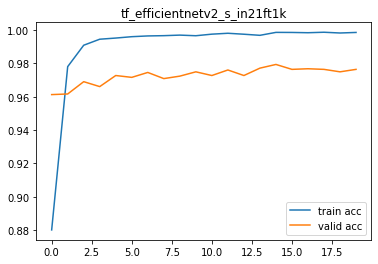

Epoch 0, Val loss: 0.0918820352483235, Acc: 0.9616236162361623, ROC: 0.994869620025312


In [43]:
#8
try:
    print(f'\033[48;5;37m\033[38;5;255m    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    {EFF_BACKBONES[INDEX]}    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    \033[0;0m')   
    EFF_train_val_infer(EFF_BACKBONES[INDEX])
except:
    pass
INDEX += 1

    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    tf_efficientnetv2_m_in21k    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-effv2-weights/tf_efficientnetv2_m_21k-361418a2.pth" to /home/ys/.cache/torch/hub/checkpoints/tf_efficientnetv2_m_21k-361418a2.pth
  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0, Train loss: 0.2304654065812839, Acc: 0.8990487124815483, ROC: 0.9677996467970683
Epoch 0, Val loss: 0.08890385994361683, Acc: 0.9690036900369003, ROC: 0.9941780274173837


  5%|▌         | 1/20 [04:46<1:30:39, 286.29s/it]

Epoch 1, Train loss: 0.05156528792262691, Acc: 0.9823683778907659, ROC: 0.9978845226719737


 10%|█         | 2/20 [09:27<1:24:55, 283.10s/it]

Epoch 1, Val loss: 0.09109079411061019, Acc: 0.970110701107011, ROC: 0.995147706013512
Epoch 2, Train loss: 0.021826514024197267, Acc: 0.9931523700180417, ROC: 0.9995658516335767
Epoch 2, Val loss: 0.072097381190203, Acc: 0.9782287822878228, ROC: 0.9961162700365414


 15%|█▌        | 3/20 [14:09<1:20:04, 282.64s/it]

Epoch 3, Train loss: 0.020229235978370338, Acc: 0.9932343775627358, ROC: 0.9996832680631469


 20%|██        | 4/20 [18:54<1:15:38, 283.65s/it]

Epoch 3, Val loss: 0.08888755573507734, Acc: 0.977490774907749, ROC: 0.995365605054366
Epoch 4, Train loss: 0.016100072888518734, Acc: 0.9945875020501886, ROC: 0.9997522386046065


 25%|██▌       | 5/20 [23:29<1:10:10, 280.68s/it]

Epoch 4, Val loss: 0.09533544373614987, Acc: 0.9723247232472325, ROC: 0.995120956259136
Epoch 5, Train loss: 0.012219733693913895, Acc: 0.9958996227652944, ROC: 0.9998570980471292


 30%|███       | 6/20 [28:04<1:05:00, 278.62s/it]

Epoch 5, Val loss: 0.10277601501393747, Acc: 0.974169741697417, ROC: 0.9960577549488439
Epoch 6, Train loss: 0.0130901148399508, Acc: 0.995612596358865, ROC: 0.9997498854596365


 35%|███▌      | 7/20 [32:42<1:00:21, 278.56s/it]

Epoch 6, Val loss: 0.09019629138010335, Acc: 0.9763837638376384, ROC: 0.9955623272063393
Epoch 7, Train loss: 0.009295170602200326, Acc: 0.9968427095292767, ROC: 0.9999300180190357


 40%|████      | 8/20 [37:30<56:15, 281.32s/it]  

Epoch 7, Val loss: 0.1271686741075204, Acc: 0.9745387453874539, ROC: 0.9935137418503808
Epoch 8, Train loss: 0.007784104681799032, Acc: 0.9972117434804002, ROC: 0.999951994466504


 45%|████▌     | 9/20 [42:20<52:04, 284.01s/it]

Epoch 8, Val loss: 0.1326031536217349, Acc: 0.9767527675276753, ROC: 0.993440180025847
Epoch 9, Train loss: 0.00916852332124588, Acc: 0.9967607019845826, ROC: 0.9999187201709633


 50%|█████     | 10/20 [47:11<47:44, 286.42s/it]

Epoch 9, Val loss: 0.09381752284466197, Acc: 0.9789667896678966, ROC: 0.9957534764928174
Epoch 10, Train loss: 0.008775362489333301, Acc: 0.9973757585697884, ROC: 0.9998666757599894


 55%|█████▌    | 11/20 [52:04<43:13, 288.18s/it]

Epoch 10, Val loss: 0.08632589887831073, Acc: 0.9767527675276753, ROC: 0.9967710817322026
Epoch 11, Train loss: 0.007409751503135589, Acc: 0.9976217812038708, ROC: 0.9998923264162706


 60%|██████    | 12/20 [56:54<38:31, 288.95s/it]

Epoch 11, Val loss: 0.13808972320436683, Acc: 0.9719557195571956, ROC: 0.9948038602124711
Epoch 12, Train loss: 0.007775099104091565, Acc: 0.9978268000656061, ROC: 0.9999300248995764


 65%|██████▌   | 13/20 [1:01:45<33:47, 289.58s/it]

Epoch 12, Val loss: 0.1097323562031576, Acc: 0.977490774907749, ROC: 0.9956102538495961
Epoch 13, Train loss: 0.006166771719851669, Acc: 0.9979498113826472, ROC: 0.9998908333389066


 70%|███████   | 14/20 [1:06:37<29:01, 290.21s/it]

Epoch 13, Val loss: 0.1120362898657579, Acc: 0.9771217712177122, ROC: 0.99618425899558
Epoch 14, Train loss: 0.0063484449650079815, Acc: 0.9984418566508119, ROC: 0.9999689825218574


 75%|███████▌  | 15/20 [1:11:30<24:16, 291.21s/it]

Epoch 14, Val loss: 0.10313042326615497, Acc: 0.9800738007380074, ROC: 0.9959128604459742
Epoch 15, Train loss: 0.006853943438532188, Acc: 0.9977037887485649, ROC: 0.999947102401961


 80%|████████  | 16/20 [1:16:21<19:23, 290.97s/it]

Epoch 15, Val loss: 0.08516415187572858, Acc: 0.9789667896678966, ROC: 0.9967069937790102
Epoch 16, Train loss: 0.005439787335170283, Acc: 0.9987288830572413, ROC: 0.9998472107099305


 85%|████████▌ | 17/20 [1:21:17<14:37, 292.51s/it]

Epoch 16, Val loss: 0.10031212061304513, Acc: 0.977490774907749, ROC: 0.9955979935455072
Epoch 17, Train loss: 0.0060586586427920945, Acc: 0.997867803837953, ROC: 0.9999685903310291


 90%|█████████ | 18/20 [1:26:10<09:45, 292.62s/it]

Epoch 17, Val loss: 0.09883651159863552, Acc: 0.9793357933579335, ROC: 0.995949641358241
Epoch 18, Train loss: 0.004162898091894996, Acc: 0.998564867967853, ROC: 0.9999889704930207


 95%|█████████▌| 19/20 [1:30:56<04:50, 290.61s/it]

Epoch 18, Val loss: 0.13570692811950505, Acc: 0.977859778597786, ROC: 0.9941156113238397
Epoch 19, Train loss: 0.00704971125184788, Acc: 0.997785796293259, ROC: 0.9998761709063596


100%|██████████| 20/20 [1:35:47<00:00, 287.37s/it]

Epoch 19, Val loss: 0.10776712974264695, Acc: 0.9785977859778597, ROC: 0.9953895683759945


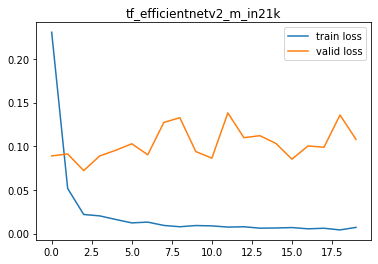

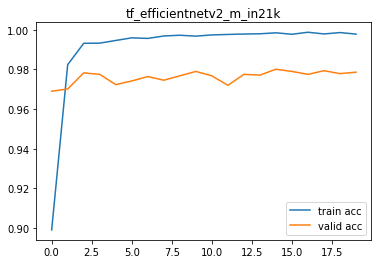

Epoch 0, Val loss: 0.07210814359760008, Acc: 0.9782287822878228, ROC: 0.9961162700365414


In [44]:
#9
try:
    print(f'\033[48;5;37m\033[38;5;255m    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    {EFF_BACKBONES[INDEX]}    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    \033[0;0m')    
    EFF_train_val_infer(EFF_BACKBONES[INDEX])
except:
    pass
INDEX += 1

In [45]:
#10
try:
    print(f'\033[48;5;37m\033[38;5;255m    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    {EFF_BACKBONES[INDEX]}    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    \033[0;0m')    
    EFF_train_val_infer(EFF_BACKBONES[INDEX])
except:
    pass
INDEX += 1

    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    tf_efficientnetv2_m_in21ft1k    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-effv2-weights/tf_efficientnetv2_m_21ft1k-bf41664a.pth" to /home/ys/.cache/torch/hub/checkpoints/tf_efficientnetv2_m_21ft1k-bf41664a.pth
  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0, Train loss: 0.22979812136596442, Acc: 0.8976955879940954, ROC: 0.9676832246056507
Epoch 0, Val loss: 0.10989099522622946, Acc: 0.9642066420664207, ROC: 0.9929274764003079


  5%|▌         | 1/20 [07:06<2:15:00, 426.33s/it]


In [46]:
#11
try:
    print(f'\033[48;5;37m\033[38;5;255m    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    {EFF_BACKBONES[INDEX]}    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    \033[0;0m')    
    EFF_train_val_infer(EFF_BACKBONES[INDEX])
except:
    pass
INDEX += 1

    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    tf_efficientnetv2_l_in21k    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    


  0%|          | 0/20 [00:00<?, ?it/s]


In [47]:
"nvidia-smi --gpu-reset" "두근두근"

'nvidia-smi --gpu-reset두근두근'

# NFNet Family

In [ ]:
len(NFN_BACKBONES)

6

In [ ]:
INDEX = 0

In [ ]:
#0
try:
    print(f'\033[48;5;230m\033[38;5;203m    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    {NFN_BACKBONES[INDEX]}    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    \033[0;0m')
    NFN_train_val_infer(NFN_BACKBONES[INDEX])
except:
    pass
INDEX += 1

In [ ]:
#1
try:
    print(f'\033[48;5;230m\033[38;5;203m    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    {NFN_BACKBONES[INDEX]}    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    \033[0;0m')
    NFN_train_val_infer(NFN_BACKBONES[INDEX])
except:
    pass
INDEX += 1

In [ ]:
#2
try:
    print(f'\033[48;5;230m\033[38;5;203m    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    {NFN_BACKBONES[INDEX]}    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    \033[0;0m')
    NFN_train_val_infer(NFN_BACKBONES[INDEX])
except:
    pass
INDEX += 1

In [ ]:
#3
try:
    print(f'\033[48;5;230m\033[38;5;203m    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    {NFN_BACKBONES[INDEX]}    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    \033[0;0m')
    NFN_train_val_infer(NFN_BACKBONES[INDEX])
except:
    pass
INDEX += 1

In [ ]:
#4
try:
    print(f'\033[48;5;230m\033[38;5;203m    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    {NFN_BACKBONES[INDEX]}    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    \033[0;0m')
    NFN_train_val_infer(NFN_BACKBONES[INDEX])
except:
    pass
INDEX += 1

In [ ]:
#5
try:
    print(f'\033[48;5;230m\033[38;5;203m    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    {NFN_BACKBONES[INDEX]}    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    \033[0;0m')
    NFN_train_val_infer(NFN_BACKBONES[INDEX])
except:
    pass
INDEX += 1

# DEIT Couple

In [ ]:
# need to resize image for using this

In [ ]:
DEIT_BACKBONES

In [ ]:
# DEIT_train_val_infer(DEIT_BACKBONES[1])